# Libraries

In [ ]:
import os
os.environ["CUDA_LAUNCH_BLOCKING"] = "1"

In [ ]:
!pip install -q "monai-weekly[nibabel, tqdm, einops]"
!python -c "import matplotlib" || pip install -q matplotlib
%matplotlib inline


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 15.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.2/42.2 kB 4.8 MB/s eta 0:00:00


In [ ]:
import os
import shutil
import tempfile

import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm
import nibabel as nib

from monai.losses import DiceCELoss, MaskedDiceLoss, DiceFocalLoss
from monai.inferers import sliding_window_inference
from monai.transforms import (
    AsDiscrete,
    AddChanneld,
    Compose,
    CropForegroundd,
    LoadImaged,
    Orientationd,
    RandFlipd,
    RandCropByPosNegLabeld,
    RandShiftIntensityd,
    ScaleIntensityRanged,
    ScaleIntensityd,
    Spacingd,
    RandRotate90d,
    RandBiasFieldd,
    RandAdjustContrastd,
    RandGaussianNoised,
    RandAffined,
    ToTensord,
    RandGaussianSharpend,
    RandHistogramShiftd,
    RandShiftIntensity,
    RandGaussianSmoothd,
    Rand3DElasticd,
    Resized,
    CenterSpatialCropd,
    AsDiscreted,
    GaussianSharpend,
    Affined



)

from monai.config import print_config
from monai.metrics import DiceMetric
from monai.networks.nets import UNet

from monai.data import (
    DataLoader,
    CacheDataset,
    load_decathlon_datalist,
    decollate_batch,
)

import torch
from torch.utils.data import random_split
# print_config()


# switch off warning messages
import warnings
warnings.filterwarnings("ignore")


In [ ]:
!nvidia-smi

Wed Sep 13 20:18:30 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.105.17   Driver Version: 525.105.17   CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   34C    P8     9W /  70W |      0MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Data Load


In [ ]:
# Load the dataset
data_dir = '/content/drive/MyDrive/RESIT/Task04_Hippocampus'
split_JSON = "dataset.json"
datasets = data_dir + "/" + split_JSON

In [ ]:
datalist = load_decathlon_datalist(datasets, True, "training")
dataset_size = len(datalist)
train_size = int(dataset_size * 0.7)
val_size = dataset_size - train_size

testlist = load_decathlon_datalist(datasets, True, "test")


train_datalist, val_datalist = random_split(datalist,[train_size, val_size])
print(datalist)
print(f"Total Data Size : {len(datalist)}")
print(f"Training Data Size : {len(train_datalist)}")
print(f"validation Data Size : {len(val_datalist)}")
print(f'Test Data Size : {len(testlist)}')

[{'image': '/content/drive/MyDrive/RESIT/Task04_Hippocampus/imagesTr/hippocampus_367.nii.gz', 'label': '/content/drive/MyDrive/RESIT/Task04_Hippocampus/labelsTr/hippocampus_367.nii.gz'}, {'image': '/content/drive/MyDrive/RESIT/Task04_Hippocampus/imagesTr/hippocampus_304.nii.gz', 'label': '/content/drive/MyDrive/RESIT/Task04_Hippocampus/labelsTr/hippocampus_304.nii.gz'}, {'image': '/content/drive/MyDrive/RESIT/Task04_Hippocampus/imagesTr/hippocampus_204.nii.gz', 'label': '/content/drive/MyDrive/RESIT/Task04_Hippocampus/labelsTr/hippocampus_204.nii.gz'}, {'image': '/content/drive/MyDrive/RESIT/Task04_Hippocampus/imagesTr/hippocampus_279.nii.gz', 'label': '/content/drive/MyDrive/RESIT/Task04_Hippocampus/labelsTr/hippocampus_279.nii.gz'}, {'image': '/content/drive/MyDrive/RESIT/Task04_Hippocampus/imagesTr/hippocampus_308.nii.gz', 'label': '/content/drive/MyDrive/RESIT/Task04_Hippocampus/labelsTr/hippocampus_308.nii.gz'}, {'image': '/content/drive/MyDrive/RESIT/Task04_Hippocampus/imagesTr/h

# STEP 1

In [ ]:
training_transforms = Compose(
    [
        LoadImaged(keys=["image", "label"]), # Load images
        AddChanneld(keys=["image", "label"]), # adding channel 1
        Resized(keys=["image", "label"], spatial_size=[64, 64, 64]), # change the image size to 64,64,64
        ToTensord(keys=["image", "label"])                           # Orignal was 35, 35, 51
    ]
)

validation_transforms = Compose(
    [
        LoadImaged(keys=["image", "label"]),
        AddChanneld(keys=["image", "label"]),
        Resized(keys=["image", "label"], spatial_size=[64, 64, 64]),
        ToTensord(keys=["image", "label"])
    ]
)



In [ ]:

# Training Datasets and DataLoader
train_ds = CacheDataset(data=train_datalist, transform=training_transforms, cache_rate=1.0, num_workers=4)
train_loader = DataLoader(train_ds, batch_size=2, shuffle=True, num_workers=4, pin_memory=True)

# Valdiation dataset and DataLoader
val_ds = CacheDataset(data=val_datalist, transform=validation_transforms, cache_rate=1.0, num_workers=4)
val_loader = DataLoader(val_ds, batch_size=2, shuffle=False, num_workers=4, pin_memory=True)

print(f"Training dataset size: {len(train_ds)}")
print(f"Validation dataset size: {len(val_ds)}")

In [ ]:
img_dim = 64
s = round(img_dim/2)

print("Image and label in training set")
for x in range(5):

    case_num = x
    img_name = train_datalist[case_num]["label"]
    label_name = train_datalist[case_num]["label"]
    case_name = os.path.split(train_ds[case_num]["image_meta_dict"]["filename_or_obj"])[1]
    case_in = train_ds[case_num]
    img = case_in["image"]
    label = case_in["label"]
    img_shape = img.shape
    label_shape = label.shape

    print(x, case_name, img_shape, label_shape)

    for plane, index in zip(["Axial", "Sagittal", "Coronal"], [s, s, s]):
      plt.figure(figsize=(24, 4))

      # Images
      plt.subplot(1, 7, 1)
      if plane == "Axial":
          plt.imshow(img[0, :, :, index], cmap="gray")
      elif plane == "Sagittal":
          plt.imshow(img[0, :, index, :], cmap="gray")
      else:  # Coronal
          plt.imshow(img[0, index, :, :], cmap="gray")
      plt.title(f"Image - {plane}")

      # Each label's channel
      for i in range(label_shape[0]):
          plt.subplot(1, 7, i+2)
          if plane == "Axial":
              plt.imshow(label[i, :, :, index], cmap="jet")
          elif plane == "Sagittal":
              plt.imshow(label[i, :, index, :], cmap="jet")
          else:  # Coronal
              plt.imshow(label[i, index, :, :], cmap="jet")
          plt.title(f"Label Channel {i} - {plane}")

    plt.tight_layout()
    plt.show()


In [ ]:
# Copyright (c) MONAI Consortium
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#     http://www.apache.org/licenses/LICENSE-2.0
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.


from monai.networks.nets import RegUNet

os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


model = RegUNet(spatial_dims = 3, # This network based by reference that mentioned
        in_channels = 1,
        num_channel_initial = 64,
        depth = 5,
        out_kernel_initializer='kaiming_uniform',
        out_activation=None,
        out_channels=1,
        extract_levels=None,
        pooling=True,
        concat_skip=True,
        encode_kernel_sizes=3
        ).to(device)

In [ ]:
from monai.losses import DiceLoss
from monai.metrics import DiceMetric

# Copyright (c) MONAI Consortium
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#     http://www.apache.org/licenses/LICENSE-2.0
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

loss_function = DiceLoss() # This Loss based by reference that mentioned
torch.backends.cudnn.benchmark = True
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-4, weight_decay=1e-5)

In [ ]:
save_dir = '/content/drive/MyDrive/RESIT/Save'

def validation(epoch_iterator_val):
    model.eval()
    dice_vals = list()
    with torch.no_grad():
        for step, batch in enumerate(epoch_iterator_val):
            val_inputs, val_labels = (batch["image"].cuda(), batch["label"].cuda())
            val_outputs = sliding_window_inference(val_inputs, (img_dim, img_dim, img_dim), 4, model)
            val_labels_list = decollate_batch(val_labels)
            val_labels_convert = [
                post_label(val_label_tensor) for val_label_tensor in val_labels_list
            ]
            val_outputs_list = decollate_batch(val_outputs)
            val_output_convert = [
                post_pred(val_pred_tensor) for val_pred_tensor in val_outputs_list
            ]
            dice_metric(y_pred=val_output_convert, y=val_labels_convert)
            dice = dice_metric.aggregate().item()
            dice_vals.append(dice)
            epoch_iterator_val.set_description(
                "Validate (%d / %d Steps) (dice=%2.5f)" % (global_step, 10.0, dice)
            )
        dice_metric.reset()
    mean_dice_val = np.mean(dice_vals)
    return mean_dice_val


def train(global_step, train_loader, dice_val_best, global_step_best):
    model.train()
    epoch_loss = 0
    step = 0
    epoch_iterator = tqdm(
        train_loader, desc="Training (X / X Steps) (loss=X.X)", dynamic_ncols=True
    )
    for step, batch in enumerate(epoch_iterator):
        step += 1
        x, y = (batch["image"].cuda(), batch["label"].cuda())
        logit_map = model(x)
        loss = loss_function(logit_map, y)
        loss.backward()
        epoch_loss += loss.item()
        optimizer.step()
        optimizer.zero_grad()
        epoch_iterator.set_description(
            "Training (%d / %d Steps) (loss=%2.5f)" % (global_step, max_iterations, loss)
        )
        if (
            global_step % eval_num == 0 and global_step != 0
        ) or global_step == max_iterations:
            epoch_iterator_val = tqdm(
                val_loader, desc="Validate (X / X Steps) (dice=X.X)", dynamic_ncols=True
            )
            dice_val = validation(epoch_iterator_val)
            epoch_loss /= step
            epoch_loss_values.append(epoch_loss)
            metric_values.append(dice_val)
            if dice_val > dice_val_best:
                dice_val_best = dice_val
                global_step_best = global_step
                torch.save(
                    model.state_dict(), os.path.join(save_dir, ("STEP1.pth"))
                )
                print(
                    "Model Was Saved ! Current Best Avg. Dice: {} Current Avg. Dice: {}".format(
                        dice_val_best, dice_val
                    )
                )
            else:
                torch.save(
                    model.state_dict(), os.path.join(save_dir, ("STEP1.pth"))
                )
                print(
                    "Model Was Not Saved ! Current Best Avg. Dice: {} Current Avg. Dice: {}".format(
                        dice_val_best, dice_val
                    )
                )
        global_step += 1
    return global_step, dice_val_best, global_step_best


# 2000 time training when it reached 200, test for validation set

In [ ]:
max_iterations = 2000
eval_num = 200
post_label = AsDiscrete(to_onehot=3)
post_pred = AsDiscrete(argmax=True, to_onehot=3)
dice_metric = DiceMetric(include_background=True, reduction="mean", get_not_nans=False)
global_step = 0
dice_val_best = 0.0
global_step_best = 0
epoch_loss_values = []
metric_values = []

In [ ]:
while global_step < max_iterations:
    global_step, dice_val_best, global_step_best = train(
        global_step, train_loader, dice_val_best, global_step_best
    )

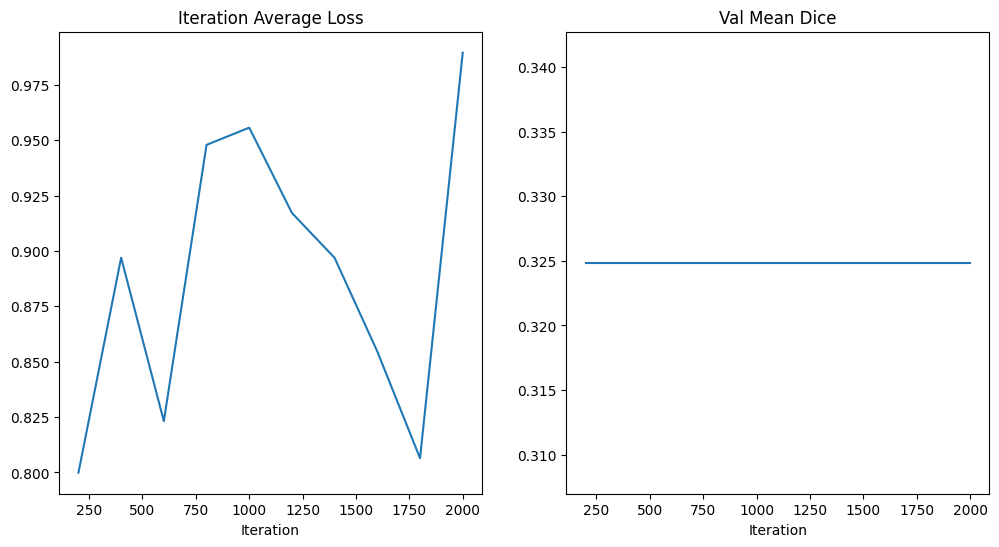

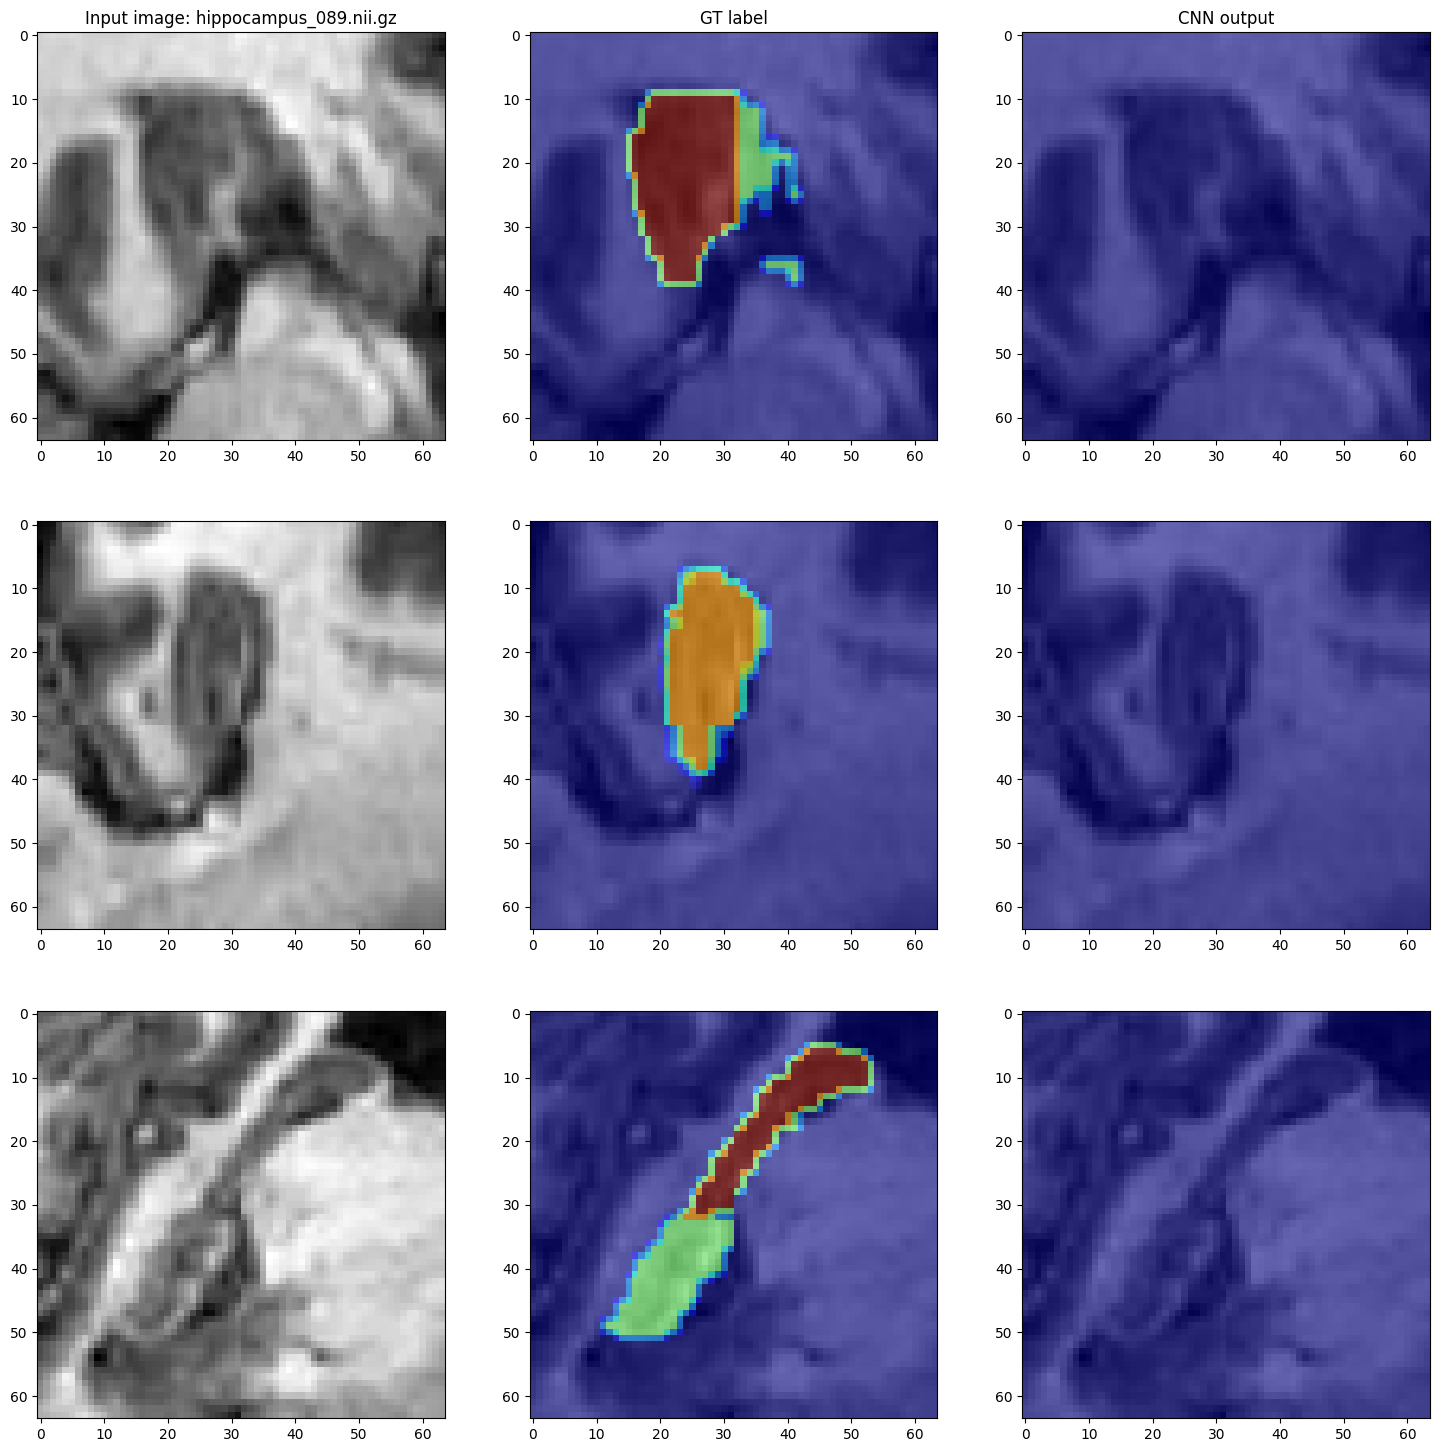

In [ ]:
plt.figure("train", (12, 6))
plt.subplot(1, 2, 1)
plt.title("Iteration Average Loss")
x = [eval_num * (i + 1) for i in range(len(epoch_loss_values))]
y = epoch_loss_values
plt.xlabel("Iteration")
plt.plot(x, y)
plt.subplot(1, 2, 2)
plt.title("Val Mean Dice")
x = [eval_num * (i + 1) for i in range(len(metric_values))]
y = metric_values
plt.xlabel("Iteration")
plt.plot(x, y)
plt.show()


case_num = 1

class_n = 2
qq=round(img_dim/2)
alpha_val = 0.6
with torch.no_grad():
    img_name = os.path.split(val_ds[case_num]["image_meta_dict"]["filename_or_obj"])[1]
    cur_case = val_ds[case_num]
    img = cur_case["image"]
    label = cur_case["label"]
    val_inputs = torch.unsqueeze(img, 1).cuda()
    val_labels = torch.unsqueeze(label, 1).cuda()
    val_outputs = sliding_window_inference(
        val_inputs, (img_dim, img_dim, img_dim), 4, model, overlap=0.8
    )
    plt.figure("check", (18, 18))
    plt.subplot(3, 3, 1)
    plt.title(f"Input image: {img_name}")
    plt.imshow(val_inputs.cpu().numpy()[0, 0, :, :, qq], cmap="gray")
    plt.subplot(3, 3, 2)
    plt.title("GT label")
    plt.imshow(val_inputs.cpu().numpy()[0, 0, :, :, qq], cmap="gray")
    plt.imshow(val_labels.cpu().numpy()[0, 0, :, :, qq], alpha=alpha_val, vmin=0, vmax=class_n, cmap="jet")
    plt.subplot(3, 3, 3)
    plt.title("CNN output")
    plt.imshow(val_inputs.cpu().numpy()[0, 0, :, :, qq], cmap="gray")
    plt.imshow(torch.argmax(val_outputs, dim=1).detach().cpu()[0, :, :, qq], alpha=alpha_val, vmin=0, vmax=class_n, cmap="jet")

    plt.subplot(3, 3, 4)
    plt.imshow(val_inputs.cpu().numpy()[0, 0, :, qq, :], cmap="gray")
    plt.subplot(3, 3, 5)
    plt.imshow(val_inputs.cpu().numpy()[0, 0, :, qq, :], cmap="gray")
    plt.imshow(val_labels.cpu().numpy()[0, 0, :, qq, :], alpha=alpha_val, vmin=0, vmax=class_n, cmap="jet")
    plt.subplot(3, 3, 6)
    plt.imshow(val_inputs.cpu().numpy()[0, 0, :, qq, :], cmap="gray")
    plt.imshow(torch.argmax(val_outputs, dim=1).detach().cpu()[0, :, qq, :], alpha=alpha_val, vmin=0, vmax=class_n, cmap="jet")


    plt.subplot(3, 3, 7)
    plt.imshow(val_inputs.cpu().numpy()[0, 0, qq, :, :], cmap="gray")
    plt.subplot(3, 3, 8)
    plt.imshow(val_inputs.cpu().numpy()[0, 0, qq, :, :], cmap="gray")
    plt.imshow(val_labels.cpu().numpy()[0, 0, qq, :, :], alpha=alpha_val, vmin=0, vmax=class_n, cmap="jet")
    plt.subplot(3, 3, 9)
    plt.imshow(val_inputs.cpu().numpy()[0, 0, qq, :, :], cmap="gray")
    plt.imshow(torch.argmax(val_outputs, dim=1).detach().cpu()[0, qq, :, :], alpha=alpha_val, vmin=0, vmax=class_n, cmap="jet")

    plt.show()

In [ ]:
# Load the model
model.load_state_dict(torch.load('/content/drive/MyDrive/RESIT/Save/best_metric_model.pth'))
model.eval()

In [ ]:
import torch

def dice_score(pred, target, epsilon=1e-6):
    intersection = (pred * target).sum()
    return (2. * intersection) / (pred.sum() + target.sum() + epsilon)

# expected and real label (0: background, 1: Anterior, 2: Posterior)
pred = torch.tensor([[0, 1, 1], [0, 1, 2], [0, 2, 2]])
target = torch.tensor([[0, 1, 1], [0, 1, 1], [0, 2, 2]])

# Calculate Dice score each labels
dice_scores = {}
for label in [0, 1, 2]:
    dice_scores[label] = dice_score((pred == label).float(), (target == label).float())

print(dice_scores)

# Calculate avearge Dice score each labels
mean_dice = sum(dice_scores.values()) / len(dice_scores)
print("Mean Dice : ",mean_dice)

# Calculate avearge Dice score each labels without background
non_background_labels = [1, 2]
mean_dice_without_background = sum(dice_scores[label] for label in non_background_labels) / len(non_background_labels)
print("Mean Dice without Background",mean_dice_without_background)

# OVERVIEW
Overview of this experiment,
- 0.7 and 0.3 ratio of training dataset and validation dataset
- Resize the image to 64, 64, 64
- UNET, Diceloss from MONAI

Results,
- 2000 times training and check the validation set every 200 each
- The Iteration average loss is unclear
- Mean Validation Dice does not work

# STEP 2 AFFINE and GAUSSIAN BLUR


In [ ]:
training_transforms2 = Compose(
    [
        LoadImaged(keys=["image", "label"]),
        AddChanneld(keys=["image", "label"]),
        Resized(keys=["image", "label"], spatial_size=[64, 64, 64]),
        Affined(
            keys=["image", "label"],
            rotate_params = [0, 0.5, 0],
            mode=("bilinear", "nearest"),
            padding_mode=("zeros"),
        ),
        GaussianSharpend(keys=['image'],
                         sigma1=2.0,
                         sigma2=1.0,
                         alpha=10.0),
        ToTensord(keys=["image", "label"])
    ]
)

validation_transforms2 = Compose(
    [
        LoadImaged(keys=["image", "label"]),
        AddChanneld(keys=["image", "label"]),
        Resized(keys=["image", "label"], spatial_size=[64, 64, 64]),
        ToTensord(keys=["image", "label"])
    ]
)


In [ ]:

# Training Datasets and DataLoader
train_ds = CacheDataset(data=train_datalist, transform=training_transforms2, cache_rate=1.0, num_workers=4)
train_loader = DataLoader(train_ds, batch_size=2, shuffle=True, num_workers=4, pin_memory=True)

# Valdiation dataset and DataLoader
val_ds = CacheDataset(data=val_datalist, transform=validation_transforms2, cache_rate=1.0, num_workers=4)
val_loader = DataLoader(val_ds, batch_size=2, shuffle=False, num_workers=4, pin_memory=True)

print(f"Training dataset size: {len(train_ds)}")
print(f"Validation dataset size: {len(val_ds)}")

Loading dataset: 100%|██████████| 78/78 [00:00<00:00, 92.86it/s]

Training dataset size: 182
Validation dataset size: 78


Image and label in training set
0 hippocampus_004.nii.gz torch.Size([1, 64, 64, 64]) torch.Size([1, 64, 64, 64])


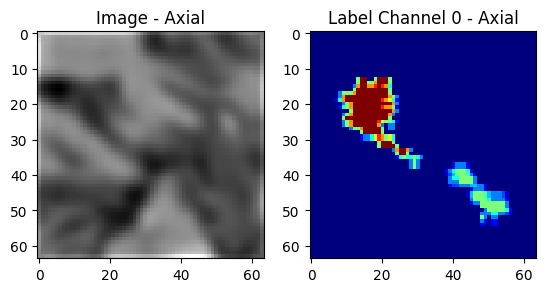

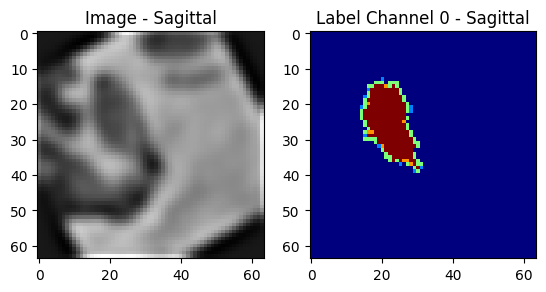

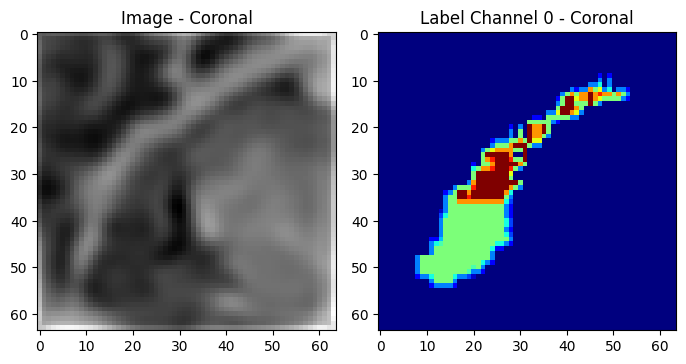

1 hippocampus_216.nii.gz torch.Size([1, 64, 64, 64]) torch.Size([1, 64, 64, 64])


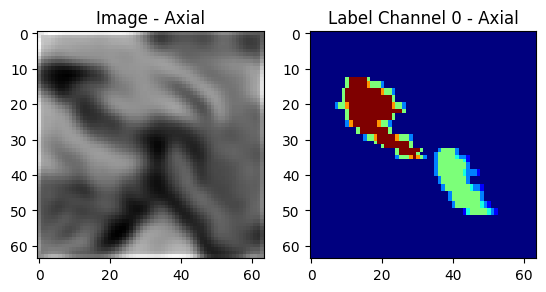

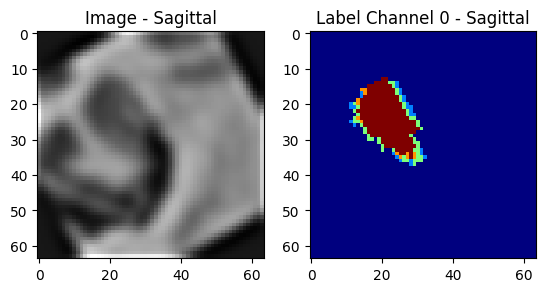

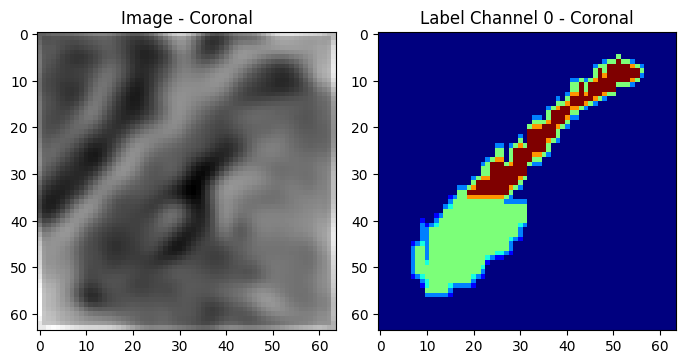

2 hippocampus_264.nii.gz torch.Size([1, 64, 64, 64]) torch.Size([1, 64, 64, 64])


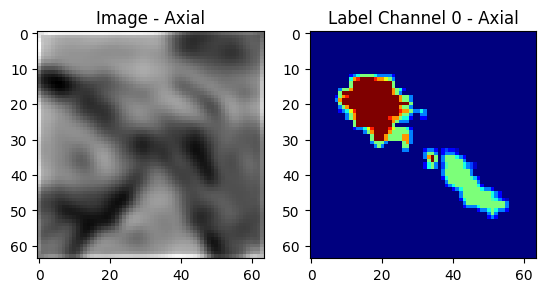

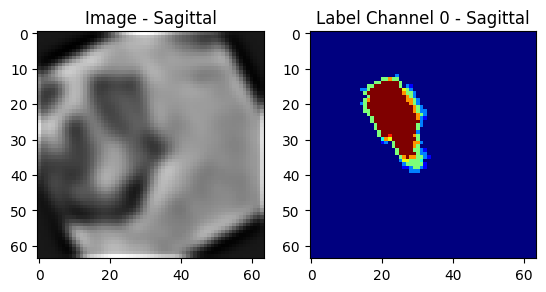

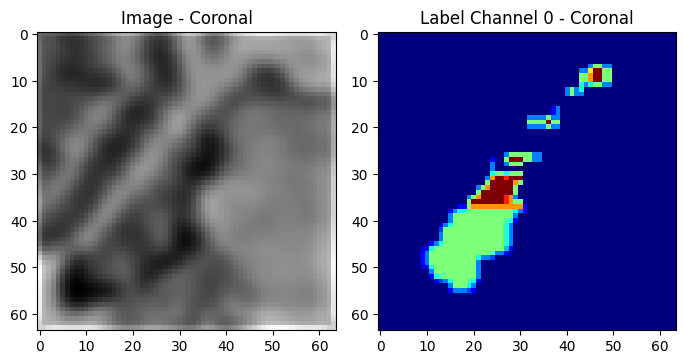

In [ ]:
img_dim = 64
s = round(img_dim/2)

print("Image and label in training set")
for x in range(3):

    case_num = x
    img_name = train_datalist[case_num]["label"]
    label_name = train_datalist[case_num]["label"]
    case_name = os.path.split(train_ds[case_num]["image_meta_dict"]["filename_or_obj"])[1]
    case_in = train_ds[case_num]
    img = case_in["image"]
    label = case_in["label"]
    img_shape = img.shape
    label_shape = label.shape

    print(x, case_name, img_shape, label_shape)

    for plane, index in zip(["Axial", "Sagittal", "Coronal"], [s, s, s]):
      plt.figure(figsize=(24, 4))

      # Images
      plt.subplot(1, 7, 1)
      if plane == "Axial":
          plt.imshow(img[0, :, :, index], cmap="gray")
      elif plane == "Sagittal":
          plt.imshow(img[0, :, index, :], cmap="gray")
      else:  # Coronal
          plt.imshow(img[0, index, :, :], cmap="gray")
      plt.title(f"Image - {plane}")

      # Each label's channel
      for i in range(label_shape[0]):
          plt.subplot(1, 7, i+2)
          if plane == "Axial":
              plt.imshow(label[i, :, :, index], cmap="jet")
          elif plane == "Sagittal":
              plt.imshow(label[i, :, index, :], cmap="jet")
          else:  # Coronal
              plt.imshow(label[i, index, :, :], cmap="jet")
          plt.title(f"Label Channel {i} - {plane}")

    plt.tight_layout()
    plt.show()


In [ ]:
save_dir = '/content/drive/MyDrive/RESIT/Save'

def validation(epoch_iterator_val):
    model.eval()
    dice_vals = list()
    with torch.no_grad():
        for step, batch in enumerate(epoch_iterator_val):
            val_inputs, val_labels = (batch["image"].cuda(), batch["label"].cuda())
            val_outputs = sliding_window_inference(val_inputs, (img_dim, img_dim, img_dim), 4, model)
            val_labels_list = decollate_batch(val_labels)
            val_labels_convert = [
                post_label(val_label_tensor) for val_label_tensor in val_labels_list
            ]
            val_outputs_list = decollate_batch(val_outputs)
            val_output_convert = [
                post_pred(val_pred_tensor) for val_pred_tensor in val_outputs_list
            ]
            dice_metric(y_pred=val_output_convert, y=val_labels_convert)
            dice = dice_metric.aggregate().item()
            dice_vals.append(dice)
            epoch_iterator_val.set_description(
                "Validate (%d / %d Steps) (dice=%2.5f)" % (global_step, 10.0, dice)
            )
        dice_metric.reset()
    mean_dice_val = np.mean(dice_vals)
    return mean_dice_val


def train(global_step, train_loader, dice_val_best, global_step_best):
    model.train()
    epoch_loss = 0
    step = 0
    epoch_iterator = tqdm(
        train_loader, desc="Training (X / X Steps) (loss=X.X)", dynamic_ncols=True
    )
    for step, batch in enumerate(epoch_iterator):
        step += 1
        x, y = (batch["image"].cuda(), batch["label"].cuda())
        logit_map = model(x)
        loss = loss_function(logit_map, y)
        loss.backward()
        epoch_loss += loss.item()
        optimizer.step()
        optimizer.zero_grad()
        epoch_iterator.set_description(
            "Training (%d / %d Steps) (loss=%2.5f)" % (global_step, max_iterations, loss)
        )
        if (
            global_step % eval_num == 0 and global_step != 0
        ) or global_step == max_iterations:
            epoch_iterator_val = tqdm(
                val_loader, desc="Validate (X / X Steps) (dice=X.X)", dynamic_ncols=True
            )
            dice_val = validation(epoch_iterator_val)
            epoch_loss /= step
            epoch_loss_values.append(epoch_loss)
            metric_values.append(dice_val)
            if dice_val > dice_val_best:
                dice_val_best = dice_val
                global_step_best = global_step
                torch.save(
                    model.state_dict(), os.path.join(save_dir, ("STEP2.pth"))
                )
                print(
                    "Model Was Saved ! Current Best Avg. Dice: {} Current Avg. Dice: {}".format(
                        dice_val_best, dice_val
                    )
                )
            else:
                torch.save(
                    model.state_dict(), os.path.join(save_dir, ("STEP2.pth"))
                )
                print(
                    "Model Was Not Saved ! Current Best Avg. Dice: {} Current Avg. Dice: {}".format(
                        dice_val_best, dice_val
                    )
                )
        global_step += 1
    return global_step, dice_val_best, global_step_best




In [ ]:
while global_step < max_iterations:
    global_step, dice_val_best, global_step_best = train(
        global_step, train_loader, dice_val_best, global_step_best
    )

Training (200 / 2000 Steps) (loss=0.86595):  21%|██        | 19/91 [00:26<05:20,  4.45s/it]

Model Was Saved ! Current Best Avg. Dice: 0.32485279517296034 Current Avg. Dice: 0.32485279517296034


Training (400 / 2000 Steps) (loss=0.83492):  41%|████      | 37/91 [00:39<04:07,  4.58s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.32485279517296034 Current Avg. Dice: 0.32485279517296034


Training (600 / 2000 Steps) (loss=0.91341):  60%|██████    | 55/91 [00:52<02:46,  4.63s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.32485279517296034 Current Avg. Dice: 0.32485279517296034


Training (800 / 2000 Steps) (loss=0.85592):  80%|████████  | 73/91 [01:05<01:23,  4.67s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.32485279517296034 Current Avg. Dice: 0.32485279517296034


Training (1000 / 2000 Steps) (loss=0.75940): 100%|██████████| 91/91 [01:18<00:00,  1.16it/s]


Model Was Not Saved ! Current Best Avg. Dice: 0.32485279517296034 Current Avg. Dice: 0.32485279517296034


Training (1200 / 2000 Steps) (loss=0.92175):  20%|█▉        | 18/91 [00:26<05:29,  4.51s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.32485279517296034 Current Avg. Dice: 0.32485279517296034


Training (1400 / 2000 Steps) (loss=0.88766):  40%|███▉      | 36/91 [00:39<04:13,  4.60s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.32485279517296034 Current Avg. Dice: 0.32485279517296034


Training (1600 / 2000 Steps) (loss=0.88055):  59%|█████▉    | 54/91 [00:51<02:48,  4.54s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.32485279517296034 Current Avg. Dice: 0.32485279517296034


Training (1800 / 2000 Steps) (loss=0.83563):  79%|███████▉  | 72/91 [01:04<01:25,  4.52s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.32485279517296034 Current Avg. Dice: 0.32485279517296034


Training (2000 / 2000 Steps) (loss=0.79976):  99%|█████████▉| 90/91 [01:17<00:04,  4.58s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.32485279517296034 Current Avg. Dice: 0.32485279517296034


Training (2001 / 2000 Steps) (loss=0.76430): 100%|██████████| 91/91 [01:18<00:00,  1.16it/s]


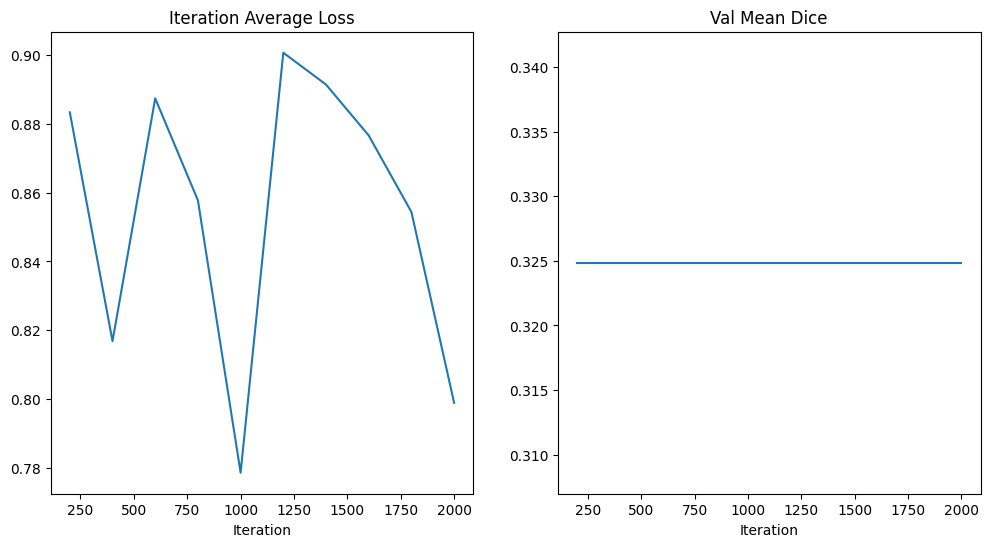

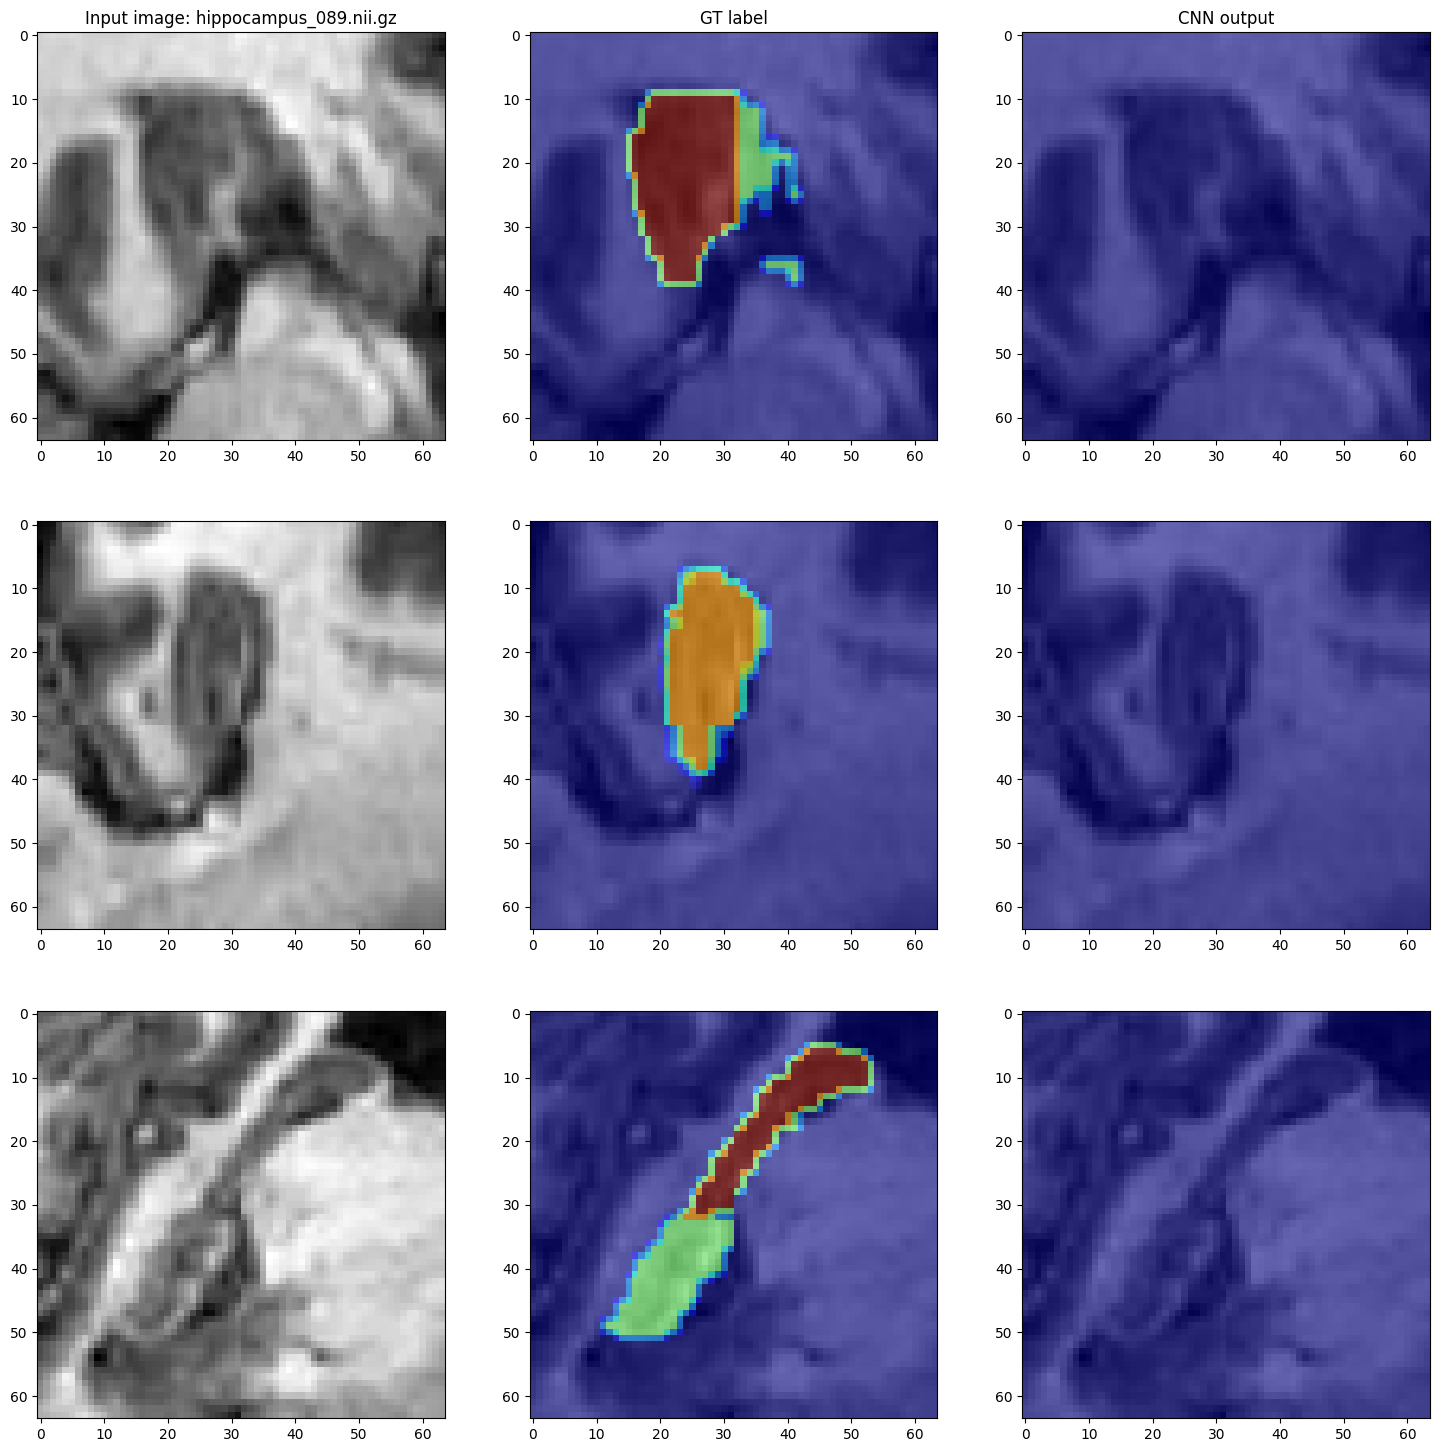

In [ ]:
plt.figure("train", (12, 6))
plt.subplot(1, 2, 1)
plt.title("Iteration Average Loss")
x = [eval_num * (i + 1) for i in range(len(epoch_loss_values))]
y = epoch_loss_values
plt.xlabel("Iteration")
plt.plot(x, y)
plt.subplot(1, 2, 2)
plt.title("Val Mean Dice")
x = [eval_num * (i + 1) for i in range(len(metric_values))]
y = metric_values
plt.xlabel("Iteration")
plt.plot(x, y)
plt.show()

case_num = 1


### Visualisation in Validation Set

class_n = 2
qq=round(img_dim/2)
alpha_val = 0.6
with torch.no_grad():
    img_name = os.path.split(val_ds[case_num]["image_meta_dict"]["filename_or_obj"])[1]
    cur_case = val_ds[case_num]
    img = cur_case["image"]
    label = cur_case["label"]
    val_inputs = torch.unsqueeze(img, 1).cuda()
    val_labels = torch.unsqueeze(label, 1).cuda()
    val_outputs = sliding_window_inference(
        val_inputs, (img_dim, img_dim, img_dim), 4, model, overlap=0.8
    )
    plt.figure("check", (18, 18))
    plt.subplot(3, 3, 1)
    plt.title(f"Input image: {img_name}")
    plt.imshow(val_inputs.cpu().numpy()[0, 0, :, :, qq], cmap="gray")
    plt.subplot(3, 3, 2)
    plt.title("GT label")
    plt.imshow(val_inputs.cpu().numpy()[0, 0, :, :, qq], cmap="gray")
    plt.imshow(val_labels.cpu().numpy()[0, 0, :, :, qq], alpha=alpha_val, vmin=0, vmax=class_n, cmap="jet")
    plt.subplot(3, 3, 3)
    plt.title("CNN output")
    plt.imshow(val_inputs.cpu().numpy()[0, 0, :, :, qq], cmap="gray")
    plt.imshow(torch.argmax(val_outputs, dim=1).detach().cpu()[0, :, :, qq], alpha=alpha_val, vmin=0, vmax=class_n, cmap="jet")

    plt.subplot(3, 3, 4)
    plt.imshow(val_inputs.cpu().numpy()[0, 0, :, qq, :], cmap="gray")
    plt.subplot(3, 3, 5)
    plt.imshow(val_inputs.cpu().numpy()[0, 0, :, qq, :], cmap="gray")
    plt.imshow(val_labels.cpu().numpy()[0, 0, :, qq, :], alpha=alpha_val, vmin=0, vmax=class_n, cmap="jet")
    plt.subplot(3, 3, 6)
    plt.imshow(val_inputs.cpu().numpy()[0, 0, :, qq, :], cmap="gray")
    plt.imshow(torch.argmax(val_outputs, dim=1).detach().cpu()[0, :, qq, :], alpha=alpha_val, vmin=0, vmax=class_n, cmap="jet")


    plt.subplot(3, 3, 7)
    plt.imshow(val_inputs.cpu().numpy()[0, 0, qq, :, :], cmap="gray")
    plt.subplot(3, 3, 8)
    plt.imshow(val_inputs.cpu().numpy()[0, 0, qq, :, :], cmap="gray")
    plt.imshow(val_labels.cpu().numpy()[0, 0, qq, :, :], alpha=alpha_val, vmin=0, vmax=class_n, cmap="jet")
    plt.subplot(3, 3, 9)
    plt.imshow(val_inputs.cpu().numpy()[0, 0, qq, :, :], cmap="gray")
    plt.imshow(torch.argmax(val_outputs, dim=1).detach().cpu()[0, qq, :, :], alpha=alpha_val, vmin=0, vmax=class_n, cmap="jet")

    plt.show()

In [ ]:
test_transforms = Compose(
    [
        LoadImaged(keys=["image"]),
        AddChanneld(keys=["image"]),
        Resized(keys=["image"], spatial_size=[64, 64, 64]),
        ToTensord(keys=["image"])
    ]
)
# test dataset and DataLoader
test_ds = CacheDataset(data=testlist, transform=test_transforms, cache_rate=1.0, num_workers=4)
test_loader = DataLoader(test_ds, batch_size=2, shuffle=False, num_workers=4, pin_memory=True)


Loading dataset: 100%|██████████| 130/130 [00:22<00:00,  5.81it/s]


TEST dataset with STEP2 networks

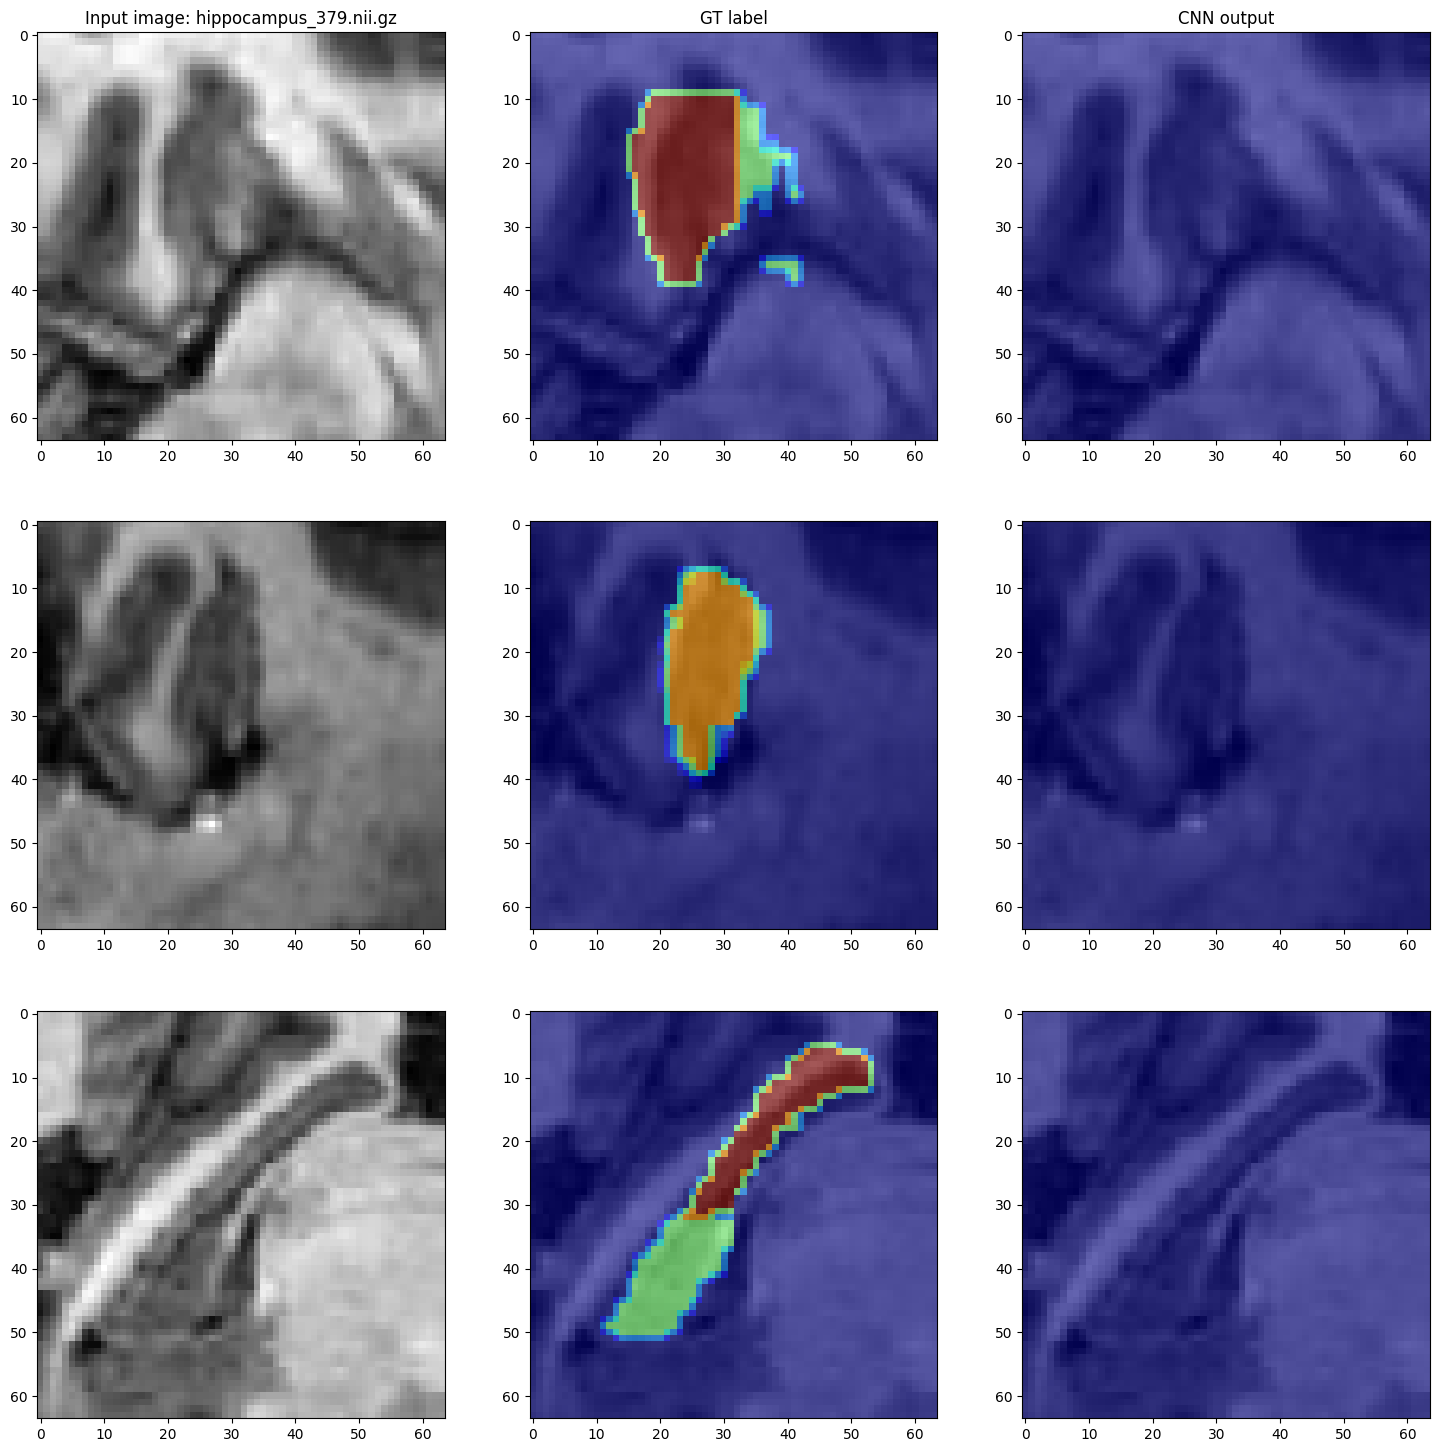

In [ ]:
case_num = 1

class_n = 2
qq=round(img_dim/2)
alpha_val = 0.6
with torch.no_grad():
    img_name = os.path.split(test_ds[case_num]["image_meta_dict"]["filename_or_obj"])[1]
    cur_case = test_ds[case_num]
    img = cur_case["image"]
    val_inputs = torch.unsqueeze(img, 1).cuda()
    val_labels = torch.unsqueeze(label, 1).cuda()
    val_outputs = sliding_window_inference(
        val_inputs, (img_dim, img_dim, img_dim), 4, model, overlap=0.8
    )
    plt.figure("check", (18, 18))
    plt.subplot(3, 3, 1)
    plt.title(f"Input image: {img_name}")
    plt.imshow(val_inputs.cpu().numpy()[0, 0, :, :, qq], cmap="gray")
    plt.subplot(3, 3, 2)
    plt.title("GT label")
    plt.imshow(val_inputs.cpu().numpy()[0, 0, :, :, qq], cmap="gray")
    plt.imshow(val_labels.cpu().numpy()[0, 0, :, :, qq], alpha=alpha_val, vmin=0, vmax=class_n, cmap="jet")
    plt.subplot(3, 3, 3)
    plt.title("CNN output")
    plt.imshow(val_inputs.cpu().numpy()[0, 0, :, :, qq], cmap="gray")
    plt.imshow(torch.argmax(val_outputs, dim=1).detach().cpu()[0, :, :, qq], alpha=alpha_val, vmin=0, vmax=class_n, cmap="jet")

    plt.subplot(3, 3, 4)
    plt.imshow(val_inputs.cpu().numpy()[0, 0, :, qq, :], cmap="gray")
    plt.subplot(3, 3, 5)
    plt.imshow(val_inputs.cpu().numpy()[0, 0, :, qq, :], cmap="gray")
    plt.imshow(val_labels.cpu().numpy()[0, 0, :, qq, :], alpha=alpha_val, vmin=0, vmax=class_n, cmap="jet")
    plt.subplot(3, 3, 6)
    plt.imshow(val_inputs.cpu().numpy()[0, 0, :, qq, :], cmap="gray")
    plt.imshow(torch.argmax(val_outputs, dim=1).detach().cpu()[0, :, qq, :], alpha=alpha_val, vmin=0, vmax=class_n, cmap="jet")


    plt.subplot(3, 3, 7)
    plt.imshow(val_inputs.cpu().numpy()[0, 0, qq, :, :], cmap="gray")
    plt.subplot(3, 3, 8)
    plt.imshow(val_inputs.cpu().numpy()[0, 0, qq, :, :], cmap="gray")
    plt.imshow(val_labels.cpu().numpy()[0, 0, qq, :, :], alpha=alpha_val, vmin=0, vmax=class_n, cmap="jet")
    plt.subplot(3, 3, 9)
    plt.imshow(val_inputs.cpu().numpy()[0, 0, qq, :, :], cmap="gray")
    plt.imshow(torch.argmax(val_outputs, dim=1).detach().cpu()[0, qq, :, :], alpha=alpha_val, vmin=0, vmax=class_n, cmap="jet")

    plt.show()

TEST dataset with STEP1 Network

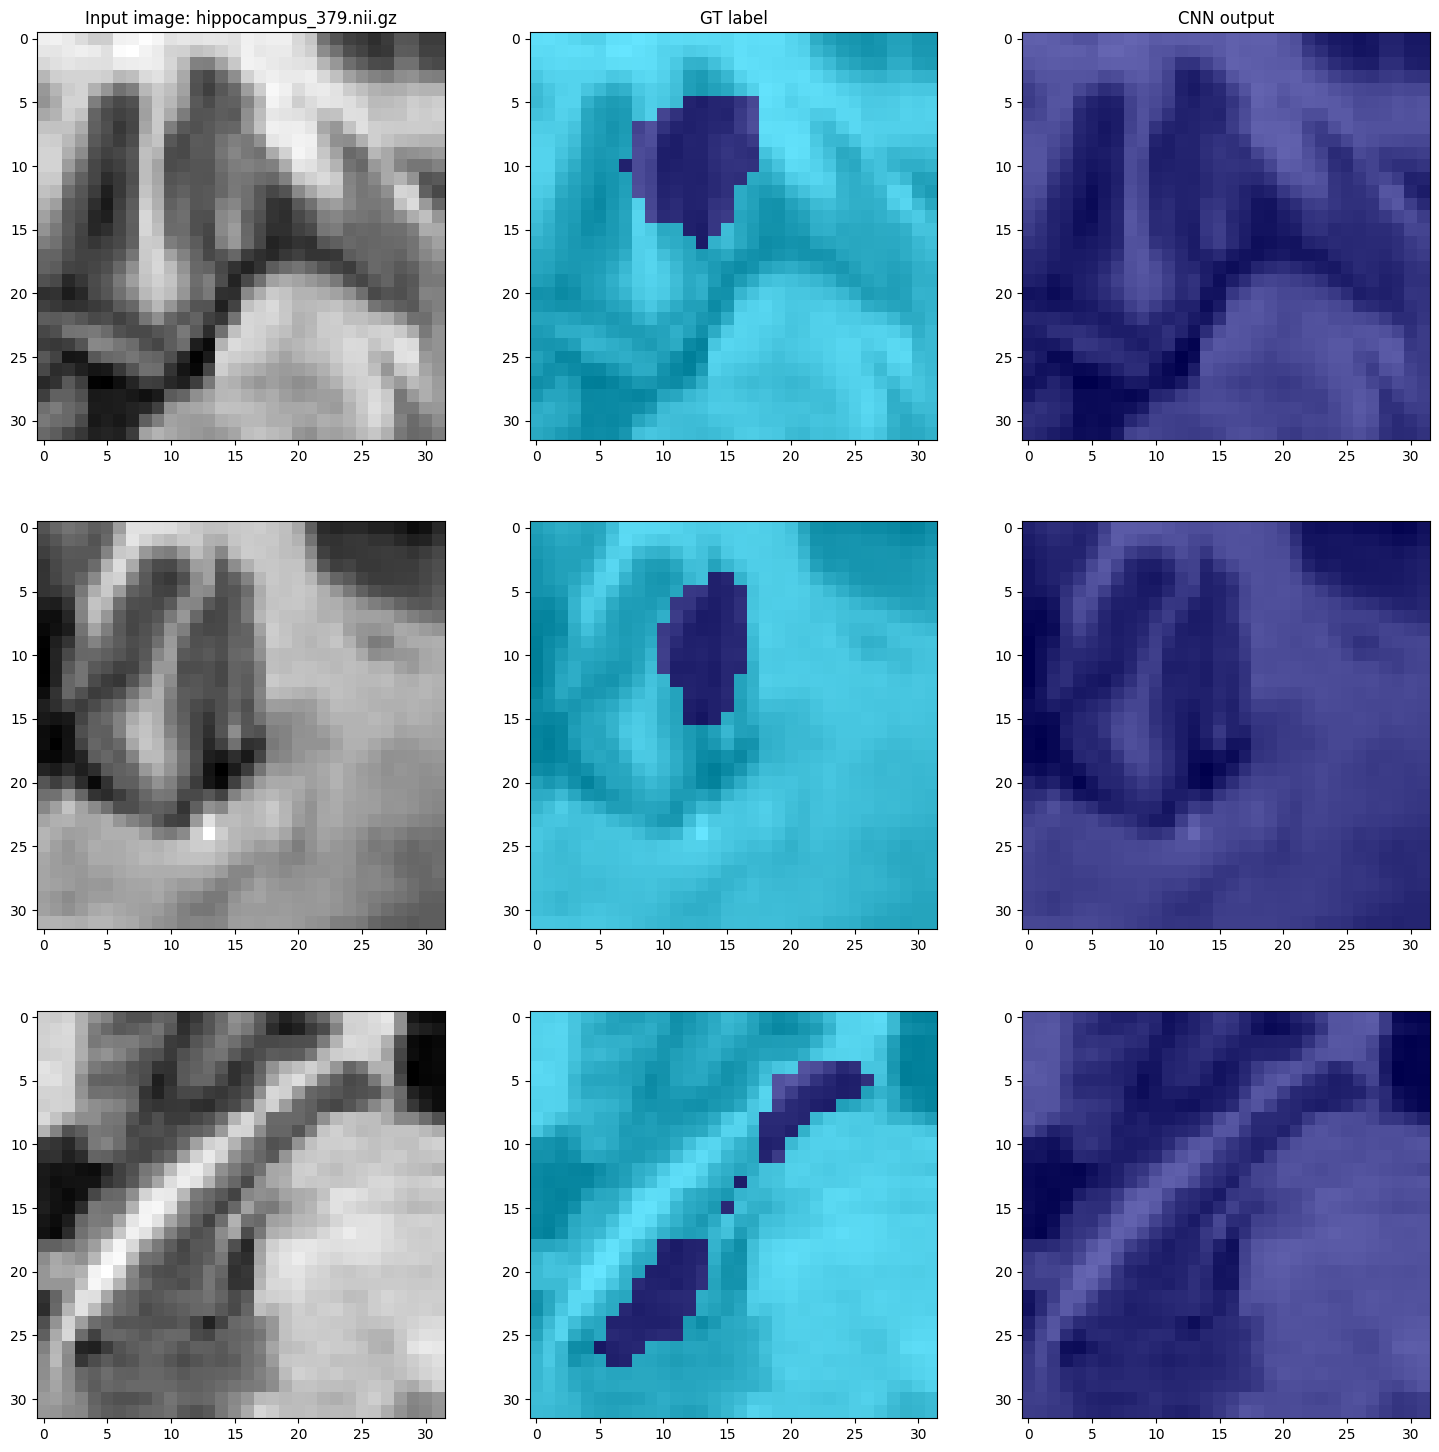

In [ ]:
case_num = 1

class_n = class_num
qq=round(img_dim/2)
alpha_val = 0.6
with torch.no_grad():
    img_name = os.path.split(test_ds[case_num]["image_meta_dict"]["filename_or_obj"])[1]
    cur_case = test_ds[case_num]
    img = cur_case["image"]
    #label = cur_case["label"]
    val_inputs = torch.unsqueeze(img, 1).cuda()
    #val_labels = torch.unsqueeze(label, 1).cuda()
    val_outputs = sliding_window_inference(
        val_inputs, (img_dim, img_dim, img_dim), 4, model, overlap=0.8
    )
    plt.figure("check", (18, 18))
    plt.subplot(3, 3, 1)
    plt.title(f"Input image: {img_name}")
    plt.imshow(val_inputs.cpu().numpy()[0, 0, :, :, qq], cmap="gray")
    plt.subplot(3, 3, 2)
    plt.title("GT label")
    plt.imshow(val_inputs.cpu().numpy()[0, 0, :, :, qq], cmap="gray")
    plt.imshow(val_labels.cpu().numpy()[0, 0, :, :, qq], alpha=alpha_val, vmin=0, vmax=class_n, cmap="jet")
    plt.subplot(3, 3, 3)
    plt.title("CNN output")
    plt.imshow(val_inputs.cpu().numpy()[0, 0, :, :, qq], cmap="gray")
    plt.imshow(torch.argmax(val_outputs, dim=1).detach().cpu()[0, :, :, qq], alpha=alpha_val, vmin=0, vmax=class_n, cmap="jet")

    plt.subplot(3, 3, 4)
    plt.imshow(val_inputs.cpu().numpy()[0, 0, :, qq, :], cmap="gray")
    plt.subplot(3, 3, 5)
    plt.imshow(val_inputs.cpu().numpy()[0, 0, :, qq, :], cmap="gray")
    plt.imshow(val_labels.cpu().numpy()[0, 0, :, qq, :], alpha=alpha_val, vmin=0, vmax=class_n, cmap="jet")
    plt.subplot(3, 3, 6)
    plt.imshow(val_inputs.cpu().numpy()[0, 0, :, qq, :], cmap="gray")
    plt.imshow(torch.argmax(val_outputs, dim=1).detach().cpu()[0, :, qq, :], alpha=alpha_val, vmin=0, vmax=class_n, cmap="jet")


    plt.subplot(3, 3, 7)
    plt.imshow(val_inputs.cpu().numpy()[0, 0, qq, :, :], cmap="gray")
    plt.subplot(3, 3, 8)
    plt.imshow(val_inputs.cpu().numpy()[0, 0, qq, :, :], cmap="gray")
    plt.imshow(val_labels.cpu().numpy()[0, 0, qq, :, :], alpha=alpha_val, vmin=0, vmax=class_n, cmap="jet")
    plt.subplot(3, 3, 9)
    plt.imshow(val_inputs.cpu().numpy()[0, 0, qq, :, :], cmap="gray")
    plt.imshow(torch.argmax(val_outputs, dim=1).detach().cpu()[0, qq, :, :], alpha=alpha_val, vmin=0, vmax=class_n, cmap="jet")

    plt.show()

In [ ]:
import torch

def dice_score(pred, target, epsilon=1e-6):
    intersection = (pred * target).sum()
    return (2. * intersection) / (pred.sum() + target.sum() + epsilon)

# expected and real label (0: background, 1: Anterior, 2: Posterior)
pred = torch.tensor([[0, 1, 1], [0, 1, 2], [0, 2, 2]])
target = torch.tensor([[0, 1, 1], [0, 1, 1], [0, 2, 2]])

# Calculate Dice score each labels
dice_scores = {}
for label in [0, 1, 2]:
    dice_scores[label] = dice_score((pred == label).float(), (target == label).float())

print(dice_scores)

# Calculate avearge Dice score each labels
mean_dice = sum(dice_scores.values()) / len(dice_scores)
print(mean_dice)

# Calculate avearge Dice score each labels without background
non_background_labels = [1, 2]
mean_dice_without_background = sum(dice_scores[label] for label in non_background_labels) / len(non_background_labels)
print(mean_dice_without_background)

{0: tensor(1.0000), 1: tensor(0.8571), 2: tensor(0.8000)}
tensor(0.8857)
tensor(0.8286)


# OVERVIEW 2
Overview of this experiment,
- AFFINE
            Affined(keys=["image", "label"],
            rotate_params = [0, 0.5, 0],
            mode=("bilinear", "nearest"),
            padding_mode=("zeros"))
  
- GAUSSIAN SHARPEN
        GaussianSharpend(keys=['image'],
                         sigma1=2.0,
                         sigma2=1.0,
                         alpha=10.0)

Results,
- 2000 times training and check the validation set every 200 each
- We can see the images and labels utilised by augmentation
- The Iteration average loss is unclear
- Mean Validation Dice does not work

We check the test dataset using STEP1 and STEP2 Experiment, but as you can see both are not trained. So, there is no segmentation in the test dataset, respectively.


# STEP 3 Change the Parameters


In [ ]:
datalist = load_decathlon_datalist(datasets, True, "training")
dataset_size = len(datalist)
train_size = int(dataset_size * 0.7)
val_size = dataset_size - train_size

train_datalist, val_datalist = random_split(datalist,[train_size, val_size])
print(datalist)
print(f"Total Data Size : {len(datalist)}")
print(f"Training Data Size : {len(train_datalist)}")
print(f"validation Data Size : {len(val_datalist)}")

[{'image': '/content/drive/MyDrive/RESIT/Task04_Hippocampus/imagesTr/hippocampus_367.nii.gz', 'label': '/content/drive/MyDrive/RESIT/Task04_Hippocampus/labelsTr/hippocampus_367.nii.gz'}, {'image': '/content/drive/MyDrive/RESIT/Task04_Hippocampus/imagesTr/hippocampus_304.nii.gz', 'label': '/content/drive/MyDrive/RESIT/Task04_Hippocampus/labelsTr/hippocampus_304.nii.gz'}, {'image': '/content/drive/MyDrive/RESIT/Task04_Hippocampus/imagesTr/hippocampus_204.nii.gz', 'label': '/content/drive/MyDrive/RESIT/Task04_Hippocampus/labelsTr/hippocampus_204.nii.gz'}, {'image': '/content/drive/MyDrive/RESIT/Task04_Hippocampus/imagesTr/hippocampus_279.nii.gz', 'label': '/content/drive/MyDrive/RESIT/Task04_Hippocampus/labelsTr/hippocampus_279.nii.gz'}, {'image': '/content/drive/MyDrive/RESIT/Task04_Hippocampus/imagesTr/hippocampus_308.nii.gz', 'label': '/content/drive/MyDrive/RESIT/Task04_Hippocampus/labelsTr/hippocampus_308.nii.gz'}, {'image': '/content/drive/MyDrive/RESIT/Task04_Hippocampus/imagesTr/h

In [ ]:
from monai.transforms import CenterSpatialCropd, SpatialPadd, ScaleIntensityd

degree_min = -3
degree_max = 3

training_transforms2 = Compose(
    [
        LoadImaged(keys=["image", "label"]),
        AddChanneld(keys=["image", "label"]),
        ScaleIntensityd(keys=["image"], minv=0.0, maxv=1.0),
        SpatialPadd(keys=["image", "label"], spatial_size=[64, 64, 64]),

        RandAffined(
            keys=["image", "label"],
            rotate_range=[(degree_min,degree_max),(degree_min,degree_max),(degree_min,degree_max)],
            mode=("bilinear", "nearest"),
            padding_mode=("zeros"),
            prob=0.5),

        RandGaussianSharpend(keys=['image'],
                            sigma1_x=(0.5, 1.5),
                            sigma1_y=(0.5, 1.5),
                            sigma1_z=(0.5, 1.5),
                            sigma2_x=(0.1, 0.5),
                            sigma2_y=(0.1, 0.5),
                            sigma2_z=(0.1, 0.5),
                            alpha=(10.0, 30.0),
                            prob=0.5),
        ToTensord(keys=["image", "label"])
    ]
)


validation_transforms2 = Compose(
    [
        LoadImaged(keys=["image", "label"]),
        AddChanneld(keys=["image", "label"]),
        ScaleIntensityd(keys=["image"], minv=0.0, maxv=1.0),
        SpatialPadd(keys=["image", "label"], spatial_size=[64, 64, 64]),
        ToTensord(keys=["image", "label"])
    ]
)


# Training Datasets and DataLoader
train_ds = CacheDataset(data=train_datalist, transform=training_transforms2, cache_rate=1.0, num_workers=4)
train_loader = DataLoader(train_ds, batch_size=2, shuffle=True, num_workers=4, pin_memory=True)

# Valdiation dataset and DataLoader
val_ds = CacheDataset(data=val_datalist, transform=validation_transforms2, cache_rate=1.0, num_workers=4)
val_loader = DataLoader(val_ds, batch_size=2, shuffle=False, num_workers=4, pin_memory=True)

print(f"Training dataset size: {len(train_ds)}")
print(f"Validation dataset size: {len(val_ds)}")




Loading dataset: 100%|██████████| 52/52 [00:25<00:00,  2.07it/s]

Training dataset size: 208
Validation dataset size: 52


Image and label in training set
0 hippocampus_004.nii.gz torch.Size([1, 64, 64, 64]) torch.Size([1, 64, 64, 64])


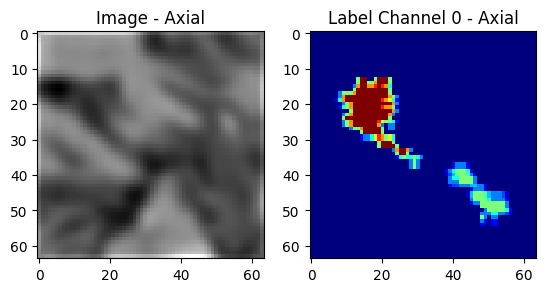

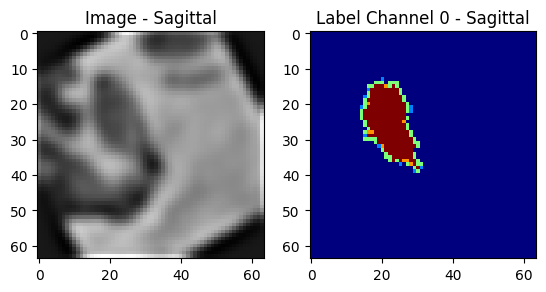

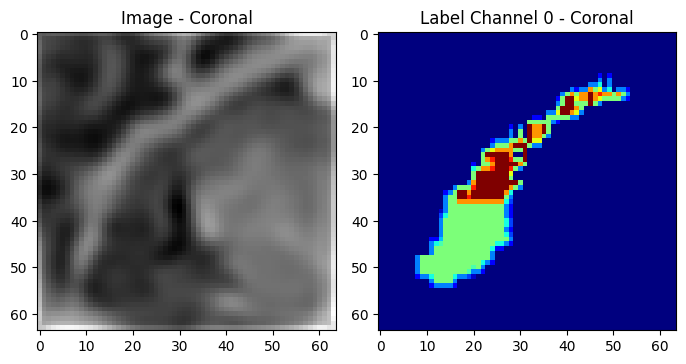

1 hippocampus_216.nii.gz torch.Size([1, 64, 64, 64]) torch.Size([1, 64, 64, 64])


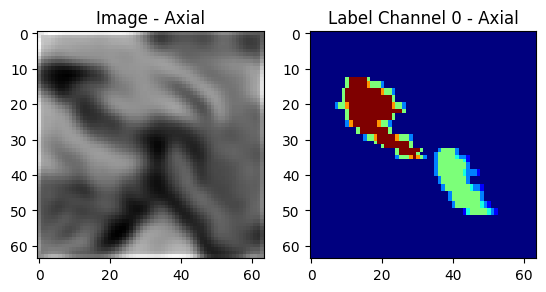

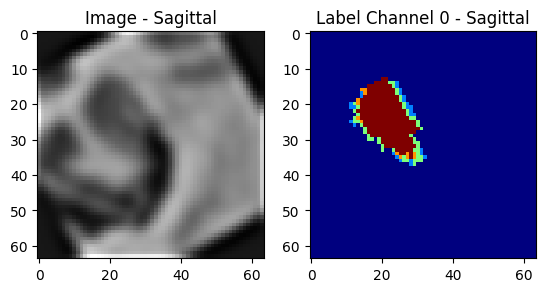

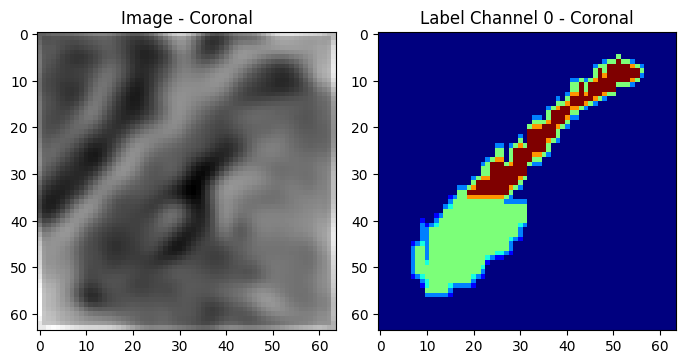

2 hippocampus_264.nii.gz torch.Size([1, 64, 64, 64]) torch.Size([1, 64, 64, 64])


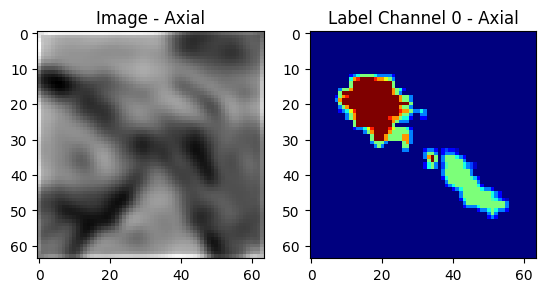

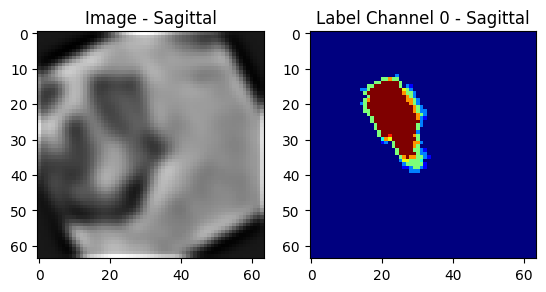

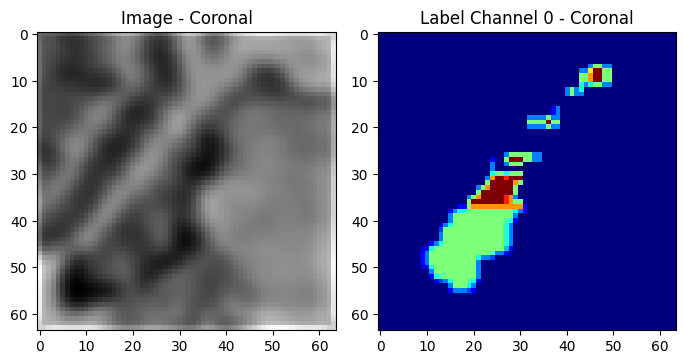

In [ ]:
img_dim = 64
s = round(img_dim/2)

print("Image and label in training set")
for x in range(3):

    case_num = x
    img_name = train_datalist[case_num]["label"]
    label_name = train_datalist[case_num]["label"]
    case_name = os.path.split(train_ds[case_num]["image_meta_dict"]["filename_or_obj"])[1]
    case_in = train_ds[case_num]
    img = case_in["image"]
    label = case_in["label"]
    img_shape = img.shape
    label_shape = label.shape

    print(x, case_name, img_shape, label_shape)

    for plane, index in zip(["Axial", "Sagittal", "Coronal"], [s, s, s]):
      plt.figure(figsize=(24, 4))

      # Images
      plt.subplot(1, 7, 1)
      if plane == "Axial":
          plt.imshow(img[0, :, :, index], cmap="gray")
      elif plane == "Sagittal":
          plt.imshow(img[0, :, index, :], cmap="gray")
      else:  # Coronal
          plt.imshow(img[0, index, :, :], cmap="gray")
      plt.title(f"Image - {plane}")

      # Each label's channel
      for i in range(label_shape[0]):
          plt.subplot(1, 7, i+2)
          if plane == "Axial":
              plt.imshow(label[i, :, :, index], cmap="jet")
          elif plane == "Sagittal":
              plt.imshow(label[i, :, index, :], cmap="jet")
          else:  # Coronal
              plt.imshow(label[i, index, :, :], cmap="jet")
          plt.title(f"Label Channel {i} - {plane}")

    plt.tight_layout()
    plt.show()


In [ ]:
from monai.losses import DiceLoss
from monai.networks.nets import RegUNet, UNet, AttentionUnet
import torch.optim as optim

os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


model = RegUNet(spatial_dims = 3,
        in_channels = 1,
        num_channel_initial = 32, # 64 -> 32 reduce the channel
        depth = 3, # 5 -> 3 reduce the depth
        out_kernel_initializer='kaiming_uniform',
        out_activation='relu',
        out_channels=3,
        extract_levels=None,
        pooling=False,
        concat_skip=False,
        encode_kernel_sizes=3
        ).to(device)



print(model)
loss_function = DiceLoss(include_background=True,
                         to_onehot_y=True,
                         sigmoid=True,
                         jaccard=True,
                         squared_pred=False
                         )

optimizer = torch.optim.Adam(model.parameters(), lr=3e-4) # 1e-4 -> 3e-4


max_iterations = 2000
eval_num = 200
post_label = AsDiscrete(to_onehot=3)
post_pred = AsDiscrete(argmax=True, to_onehot=3)
dice_metric = DiceMetric(include_background=True, reduction="mean", get_not_nans=False)
global_step = 0
dice_val_best = 0.0
global_step_best = 0
epoch_loss_values = []
metric_values = []

RegUNet(
  (encode_convs): ModuleList(
    (0): Sequential(
      (0): Convolution(
        (conv): Conv3d(1, 32, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1), bias=False)
        (adn): ADN(
          (N): BatchNorm3d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (A): ReLU()
        )
      )
      (1): RegistrationResidualConvBlock(
        (layers): ModuleList(
          (0-1): 2 x Convolution(
            (conv): Conv3d(32, 32, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1), bias=False)
          )
        )
        (norms): ModuleList(
          (0-1): 2 x BatchNorm3d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        )
        (acts): ModuleList(
          (0-1): 2 x ReLU()
        )
      )
    )
    (1): Sequential(
      (0): Convolution(
        (conv): Conv3d(32, 64, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1), bias=False)
        (adn): ADN(
          (N): BatchNorm3d(64, eps=1

In [ ]:
save_dir = '/content/drive/MyDrive/RESIT/Save'

def validation(epoch_iterator_val):
    model.eval()
    dice_vals = list()
    with torch.no_grad():
        for step, batch in enumerate(epoch_iterator_val):
            val_inputs, val_labels = (batch["image"].cuda(), batch["label"].cuda())
            val_outputs = sliding_window_inference(val_inputs, (img_dim, img_dim, img_dim), 4, model)
            val_labels_list = decollate_batch(val_labels)
            val_labels_convert = [
                post_label(val_label_tensor) for val_label_tensor in val_labels_list
            ]
            val_outputs_list = decollate_batch(val_outputs)
            val_output_convert = [
                post_pred(val_pred_tensor) for val_pred_tensor in val_outputs_list
            ]
            dice_metric(y_pred=val_output_convert, y=val_labels_convert)
            dice = dice_metric.aggregate().item()
            dice_vals.append(dice)
            epoch_iterator_val.set_description(
                "Validate (%d / %d Steps) (dice=%2.5f)" % (global_step, 10.0, dice)
            )
        dice_metric.reset()
    mean_dice_val = np.mean(dice_vals)
    return mean_dice_val


def train(global_step, train_loader, dice_val_best, global_step_best):
    model.train()
    epoch_loss = 0
    step = 0
    epochs_no_improve = 0 # 추가
    max_epochs_no_improve = 20 # patients
    epoch_iterator = tqdm(
        train_loader, desc="Training (X / X Steps) (loss=X.X)", dynamic_ncols=True
    )
    for step, batch in enumerate(epoch_iterator):
        step += 1
        x, y = (batch["image"].cuda(), batch["label"].cuda())
        logit_map = model(x)
        loss = loss_function(logit_map, y)
        loss.backward()
        epoch_loss += loss.item()
        optimizer.step()
        optimizer.zero_grad()
        epoch_iterator.set_description(
            "Training (%d / %d Steps) (loss=%2.5f)" % (global_step, max_iterations, loss)
        )
        if (
            global_step % eval_num == 0 and global_step != 0
        ) or global_step == max_iterations:
            epoch_iterator_val = tqdm(
                val_loader, desc="Validate (X / X Steps) (dice=X.X)", dynamic_ncols=True
            )
            dice_val = validation(epoch_iterator_val)
            epoch_loss /= step
            epoch_loss_values.append(epoch_loss)
            metric_values.append(dice_val)
            if dice_val > dice_val_best:
                dice_val_best = dice_val
                epochs_no_improve = 0
                global_step_best = global_step
                torch.save(
                    model.state_dict(), os.path.join(save_dir, ("best_teest3_64_b1_3_adam_20000.pth"))
                )
                print(
                    "Model Was Saved ! Current Best Avg. Dice: {} Current Avg. Dice: {}".format(
                        dice_val_best, dice_val
                    )
                )
            else:
                epochs_no_improve += 1
                torch.save(
                    model.state_dict(), os.path.join(save_dir, ("best_teest3_64_b1_3_adam_20000.pth"))
                )
                print(
                    "Model Was Not Saved ! Current Best Avg. Dice: {} Current Avg. Dice: {}".format(
                        dice_val_best, dice_val
                    )
                )
                print("[{}/20]".format(epochs_no_improve))
            if epochs_no_improve == max_epochs_no_improve:
                print("Early stopping!")
                break
        global_step += 1
    return global_step, dice_val_best, global_step_best




Training (201 / 2000 Steps) (loss=0.66328):  22%|██▏       | 20/91 [00:07<00:56,  1.26it/s]

Model Was Saved ! Current Best Avg. Dice: 0.3312560228201059 Current Avg. Dice: 0.3312560228201059


Training (401 / 2000 Steps) (loss=0.66314):  42%|████▏     | 38/91 [00:10<00:43,  1.23it/s]

Model Was Saved ! Current Best Avg. Dice: 0.38468023141225177 Current Avg. Dice: 0.38468023141225177


Training (601 / 2000 Steps) (loss=0.66349):  62%|██████▏   | 56/91 [00:14<00:28,  1.25it/s]

Model Was Saved ! Current Best Avg. Dice: 0.6070411403973898 Current Avg. Dice: 0.6070411403973898


Training (801 / 2000 Steps) (loss=0.66339):  81%|████████▏ | 74/91 [00:17<00:13,  1.24it/s]

Model Was Not Saved ! Current Best Avg. Dice: 0.6070411403973898 Current Avg. Dice: 0.5506935089062421


Training (1000 / 2000 Steps) (loss=0.66261): 100%|██████████| 91/91 [00:20<00:00,  4.36it/s]


Model Was Not Saved ! Current Best Avg. Dice: 0.6070411403973898 Current Avg. Dice: 0.5739699540994107


Training (1201 / 2000 Steps) (loss=0.66319):  21%|██        | 19/91 [00:07<00:59,  1.22it/s]

Model Was Not Saved ! Current Best Avg. Dice: 0.6070411403973898 Current Avg. Dice: 0.5747463382207431


Training (1401 / 2000 Steps) (loss=0.66382):  41%|████      | 37/91 [00:10<00:43,  1.25it/s]

Model Was Not Saved ! Current Best Avg. Dice: 0.6070411403973898 Current Avg. Dice: 0.6059594994936234


Training (1601 / 2000 Steps) (loss=0.66328):  60%|██████    | 55/91 [00:14<00:29,  1.21it/s]

Model Was Not Saved ! Current Best Avg. Dice: 0.6070411403973898 Current Avg. Dice: 0.6039308875035017


Training (1801 / 2000 Steps) (loss=0.66303):  80%|████████  | 73/91 [00:17<00:14,  1.26it/s]

Model Was Not Saved ! Current Best Avg. Dice: 0.6070411403973898 Current Avg. Dice: 0.5821831211065635


Training (2001 / 2000 Steps) (loss=0.66299): 100%|██████████| 91/91 [00:20<00:00,  1.30it/s]

Model Was Not Saved ! Current Best Avg. Dice: 0.6070411403973898 Current Avg. Dice: 0.6054403353960086


Training (2001 / 2000 Steps) (loss=0.66299): 100%|██████████| 91/91 [00:20<00:00,  4.37it/s]


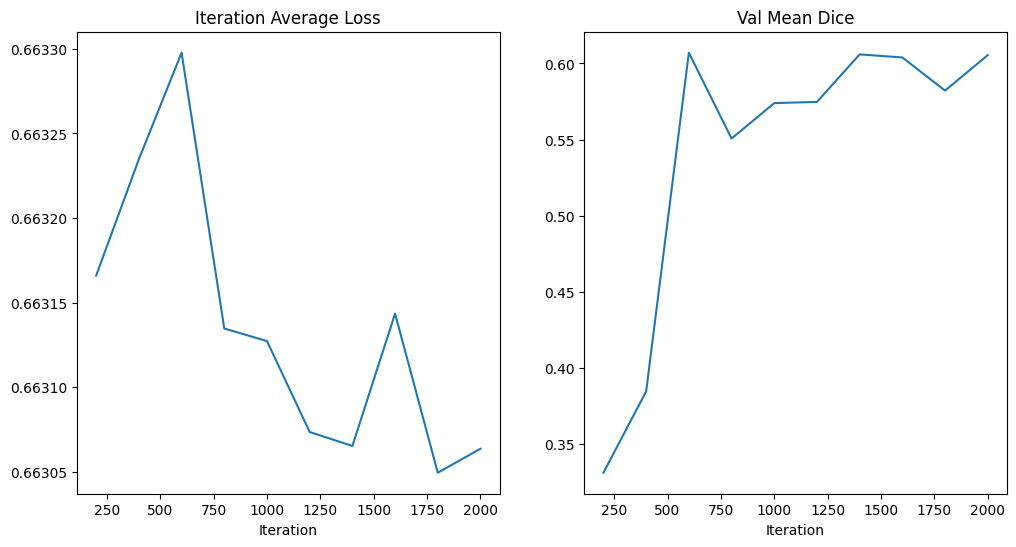

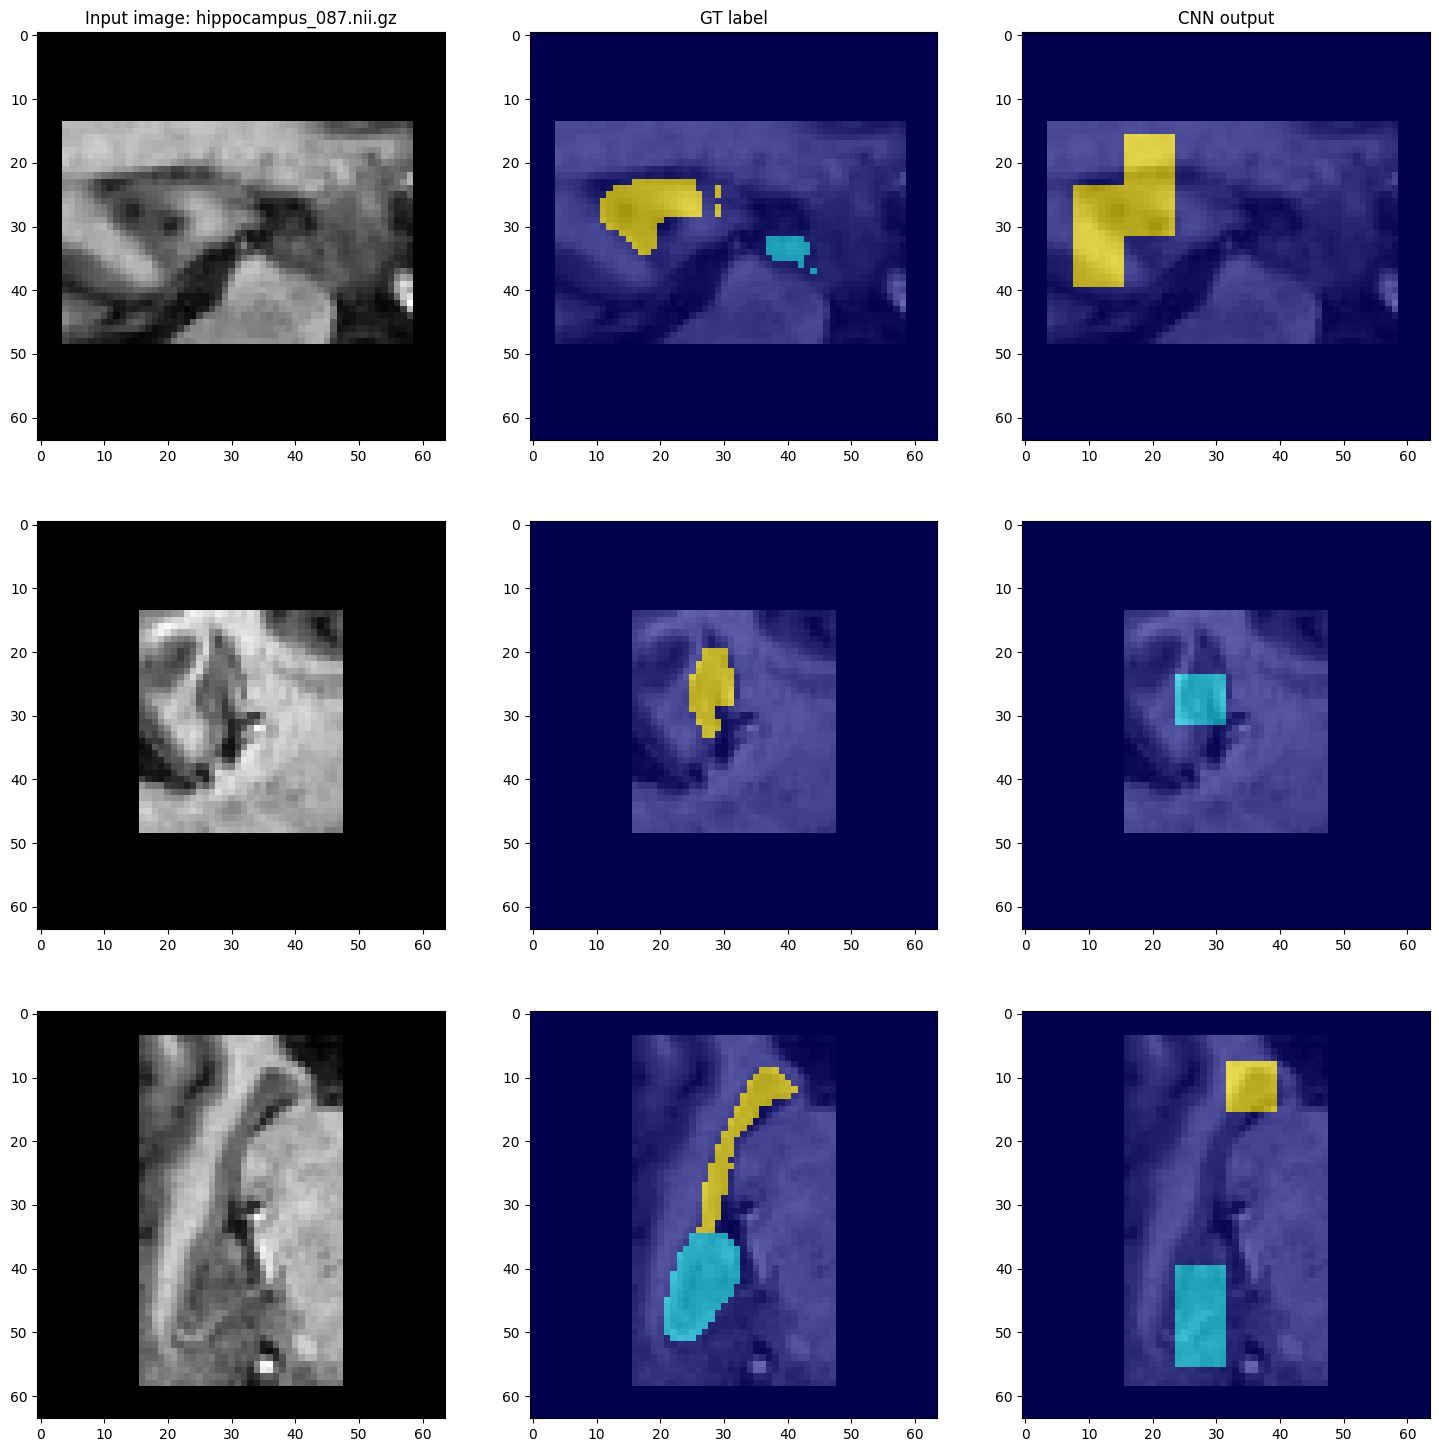

In [ ]:
while global_step < max_iterations:
    global_step, dice_val_best, global_step_best = train(
        global_step, train_loader, dice_val_best, global_step_best
    )

plt.figure("train", (12, 6))
plt.subplot(1, 2, 1)
plt.title("Iteration Average Loss")
x = [eval_num * (i + 1) for i in range(len(epoch_loss_values))]
y = epoch_loss_values
plt.xlabel("Iteration")
plt.plot(x, y)
plt.subplot(1, 2, 2)
plt.title("Val Mean Dice")
x = [eval_num * (i + 1) for i in range(len(metric_values))]
y = metric_values
plt.xlabel("Iteration")
plt.plot(x, y)
plt.show()

case_num = 1

class_n = 3
qq=round(img_dim/2)
alpha_val = 0.6
with torch.no_grad():
    img_name = os.path.split(val_ds[case_num]["image_meta_dict"]["filename_or_obj"])[1]
    cur_case = val_ds[case_num]
    img = cur_case["image"]
    label = cur_case["label"]
    val_inputs = torch.unsqueeze(img, 1).cuda()
    val_labels = torch.unsqueeze(label, 1).cuda()
    val_outputs = sliding_window_inference(
        val_inputs, (img_dim, img_dim, img_dim), 4, model, overlap=0.8
    )
    plt.figure("check", (18, 18))
    plt.subplot(3, 3, 1)
    plt.title(f"Input image: {img_name}")
    plt.imshow(val_inputs.cpu().numpy()[0, 0, :, :, qq], cmap="gray")
    plt.subplot(3, 3, 2)
    plt.title("GT label")
    plt.imshow(val_inputs.cpu().numpy()[0, 0, :, :, qq], cmap="gray")
    plt.imshow(val_labels.cpu().numpy()[0, 0, :, :, qq], alpha=alpha_val, vmin=0, vmax=class_n, cmap="jet")
    plt.subplot(3, 3, 3)
    plt.title("CNN output")
    plt.imshow(val_inputs.cpu().numpy()[0, 0, :, :, qq], cmap="gray")
    plt.imshow(torch.argmax(val_outputs, dim=1).detach().cpu()[0, :, :, qq], alpha=alpha_val, vmin=0, vmax=class_n, cmap="jet")

    plt.subplot(3, 3, 4)
    plt.imshow(val_inputs.cpu().numpy()[0, 0, :, qq, :], cmap="gray")
    plt.subplot(3, 3, 5)
    plt.imshow(val_inputs.cpu().numpy()[0, 0, :, qq, :], cmap="gray")
    plt.imshow(val_labels.cpu().numpy()[0, 0, :, qq, :], alpha=alpha_val, vmin=0, vmax=class_n, cmap="jet")
    plt.subplot(3, 3, 6)
    plt.imshow(val_inputs.cpu().numpy()[0, 0, :, qq, :], cmap="gray")
    plt.imshow(torch.argmax(val_outputs, dim=1).detach().cpu()[0, :, qq, :], alpha=alpha_val, vmin=0, vmax=class_n, cmap="jet")


    plt.subplot(3, 3, 7)
    plt.imshow(val_inputs.cpu().numpy()[0, 0, qq, :, :], cmap="gray")
    plt.subplot(3, 3, 8)
    plt.imshow(val_inputs.cpu().numpy()[0, 0, qq, :, :], cmap="gray")
    plt.imshow(val_labels.cpu().numpy()[0, 0, qq, :, :], alpha=alpha_val, vmin=0, vmax=class_n, cmap="jet")
    plt.subplot(3, 3, 9)
    plt.imshow(val_inputs.cpu().numpy()[0, 0, qq, :, :], cmap="gray")
    plt.imshow(torch.argmax(val_outputs, dim=1).detach().cpu()[0, qq, :, :], alpha=alpha_val, vmin=0, vmax=class_n, cmap="jet")
# adamW 3e-4
    plt.show()

In [ ]:
# Load the model
model.load_state_dict(torch.load('/content/drive/MyDrive/RESIT/Save/best_teest3_64_b1_3_adam_20000.pth'))
model.eval()

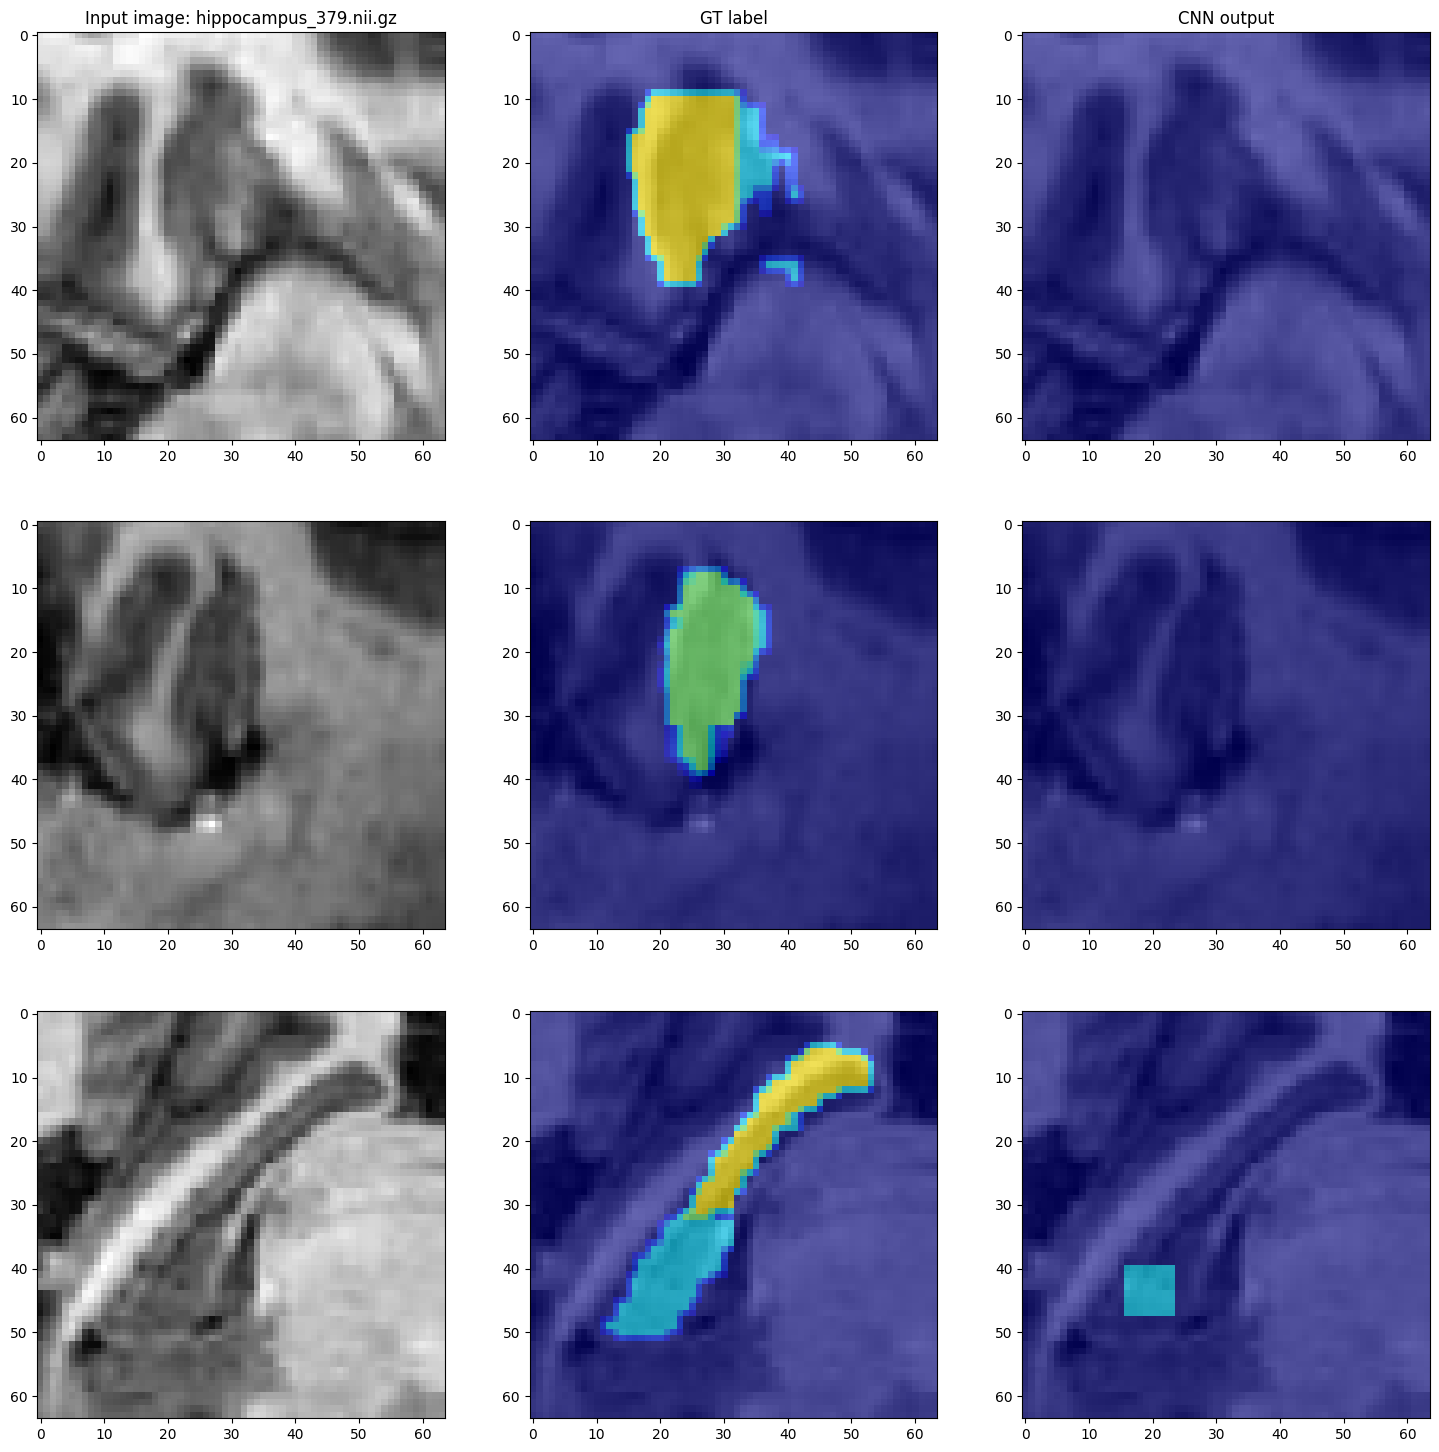

In [ ]:
case_num = 1

class_n = 3
qq=round(img_dim/2)
alpha_val = 0.6
with torch.no_grad():
    img_name = os.path.split(test_ds[case_num]["image_meta_dict"]["filename_or_obj"])[1]
    cur_case = test_ds[case_num]
    img = cur_case["image"]
    val_inputs = torch.unsqueeze(img, 1).cuda()
    val_outputs = sliding_window_inference(
        val_inputs, (img_dim, img_dim, img_dim), 4, model, overlap=0.8
    )
    plt.figure("check", (18, 18))
    plt.subplot(3, 3, 1)
    plt.title(f"Input image: {img_name}")
    plt.imshow(val_inputs.cpu().numpy()[0, 0, :, :, qq], cmap="gray")
    plt.subplot(3, 3, 2)
    plt.title("GT label")
    plt.imshow(val_inputs.cpu().numpy()[0, 0, :, :, qq], cmap="gray")
    plt.imshow(val_labels.cpu().numpy()[0, 0, :, :, qq], alpha=alpha_val, vmin=0, vmax=class_n, cmap="jet")
    plt.subplot(3, 3, 3)
    plt.title("CNN output")
    plt.imshow(val_inputs.cpu().numpy()[0, 0, :, :, qq], cmap="gray")
    plt.imshow(torch.argmax(val_outputs, dim=1).detach().cpu()[0, :, :, qq], alpha=alpha_val, vmin=0, vmax=class_n, cmap="jet")

    plt.subplot(3, 3, 4)
    plt.imshow(val_inputs.cpu().numpy()[0, 0, :, qq, :], cmap="gray")
    plt.subplot(3, 3, 5)
    plt.imshow(val_inputs.cpu().numpy()[0, 0, :, qq, :], cmap="gray")
    plt.imshow(val_labels.cpu().numpy()[0, 0, :, qq, :], alpha=alpha_val, vmin=0, vmax=class_n, cmap="jet")
    plt.subplot(3, 3, 6)
    plt.imshow(val_inputs.cpu().numpy()[0, 0, :, qq, :], cmap="gray")
    plt.imshow(torch.argmax(val_outputs, dim=1).detach().cpu()[0, :, qq, :], alpha=alpha_val, vmin=0, vmax=class_n, cmap="jet")


    plt.subplot(3, 3, 7)
    plt.imshow(val_inputs.cpu().numpy()[0, 0, qq, :, :], cmap="gray")
    plt.subplot(3, 3, 8)
    plt.imshow(val_inputs.cpu().numpy()[0, 0, qq, :, :], cmap="gray")
    plt.imshow(val_labels.cpu().numpy()[0, 0, qq, :, :], alpha=alpha_val, vmin=0, vmax=class_n, cmap="jet")
    plt.subplot(3, 3, 9)
    plt.imshow(val_inputs.cpu().numpy()[0, 0, qq, :, :], cmap="gray")
    plt.imshow(torch.argmax(val_outputs, dim=1).detach().cpu()[0, qq, :, :], alpha=alpha_val, vmin=0, vmax=class_n, cmap="jet")
# adam 3e-4
    plt.show()

# OVERVIEW 3
- NETWORK
  - Initial Number of Channel 64 to 32
  - Depth : 5 -> 3
- DICE LOSS
  - Parameters:
    - Include background
    - Sigmoid Activation
    - Jaccard (IoU)
- OPTIMISER ADAMW
  - Learning Rate
    - 1e-3 to 3e-4
- AUGMENTATION
  - AFFINE -> RANDOM AFFINE
          RandAffined(
            keys=["image", "label"],
            rotate_range=[(degree_min,degree_max),(degree_min,degree_max),(degree_min,degree_max)],
            mode=("bilinear", "nearest"),
            padding_mode=("zeros"),
            prob=0.5)
  - GAUSSIAN BLUR -> RANDOM GAUNSSIAN SHARPEN
          RandGaussianSharpend(keys=['image'],
                            sigma1_x=(0.5, 1.5),
                            sigma1_y=(0.5, 1.5),
                            sigma1_z=(0.5, 1.5),
                            sigma2_x=(0.1, 0.5),
                            sigma2_y=(0.1, 0.5),
                            sigma2_z=(0.1, 0.5),
                            alpha=(10.0, 30.0),
                            prob=0.5)
  - Scale Intensity
            ScaleIntensityd(keys=["image"], minv=0.0, maxv=1.0),


#RESULTS
Training worked,
- 0.607 best dice in Valdiation set
- Iteration Average Loss also keep decreasing.
- However, It does not work in Test Dataset


# Attention UNET

Training (200 / 2000 Steps) (loss=0.72962):  93%|█████████▎| 97/104 [00:36<00:10,  1.45s/it]

Model Was Saved ! Current Best Avg. Dice: 0.4088843831649193 Current Avg. Dice: 0.4088843831649193


Training (400 / 2000 Steps) (loss=0.68792):  86%|████████▌ | 89/104 [00:34<00:21,  1.45s/it]

Model Was Saved ! Current Best Avg. Dice: 0.5381723596499517 Current Avg. Dice: 0.5381723596499517


Training (600 / 2000 Steps) (loss=0.62087):  78%|███████▊  | 81/104 [00:31<00:34,  1.50s/it]

Model Was Saved ! Current Best Avg. Dice: 0.5666859127007998 Current Avg. Dice: 0.5666859127007998


Training (800 / 2000 Steps) (loss=0.46492):  70%|███████   | 73/104 [00:27<00:44,  1.44s/it]

Model Was Saved ! Current Best Avg. Dice: 0.8575800886520972 Current Avg. Dice: 0.8575800886520972


Training (1000 / 2000 Steps) (loss=0.24384):  62%|██████▎   | 65/104 [00:26<01:04,  1.66s/it]

Model Was Saved ! Current Best Avg. Dice: 0.8888136056753305 Current Avg. Dice: 0.8888136056753305


Training (1200 / 2000 Steps) (loss=0.27354):  55%|█████▍    | 57/104 [00:22<01:07,  1.44s/it]

Model Was Saved ! Current Best Avg. Dice: 0.8895553808945876 Current Avg. Dice: 0.8895553808945876


Training (1400 / 2000 Steps) (loss=0.24489):  47%|████▋     | 49/104 [00:20<01:18,  1.42s/it]

Model Was Saved ! Current Best Avg. Dice: 0.9074804737017705 Current Avg. Dice: 0.9074804737017705


Training (1600 / 2000 Steps) (loss=0.23247):  39%|███▉      | 41/104 [00:17<01:31,  1.46s/it]

Model Was Saved ! Current Best Avg. Dice: 0.9100802815877475 Current Avg. Dice: 0.9100802815877475


Training (1800 / 2000 Steps) (loss=0.21848):  32%|███▏      | 33/104 [00:15<01:44,  1.47s/it]

Model Was Saved ! Current Best Avg. Dice: 0.9121515911359054 Current Avg. Dice: 0.9121515911359054


Training (2000 / 2000 Steps) (loss=0.23388):  24%|██▍       | 25/104 [00:12<01:55,  1.47s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.9121515911359054 Current Avg. Dice: 0.9119028059335855
[1/20]


Training (2079 / 2000 Steps) (loss=0.27028): 100%|██████████| 104/104 [00:38<00:00,  2.74it/s]


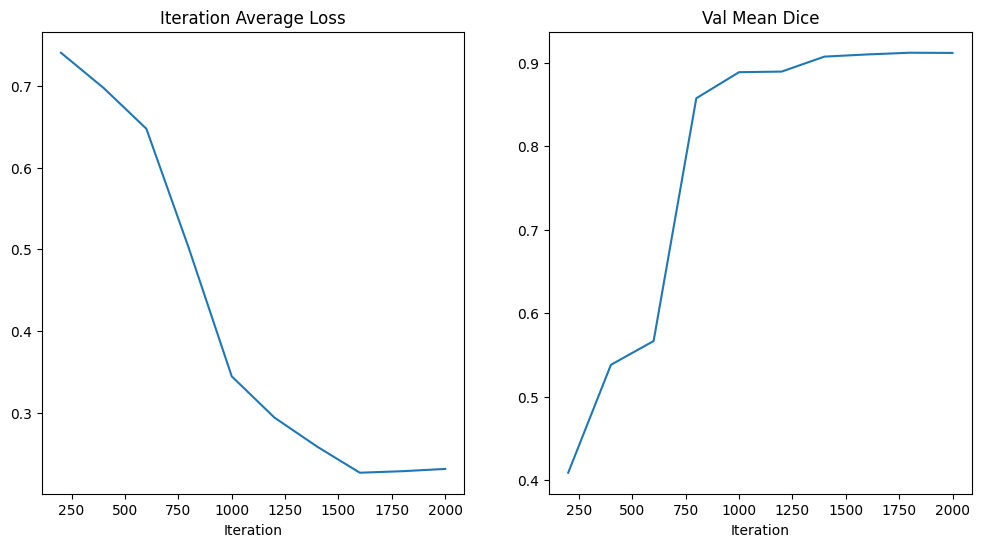

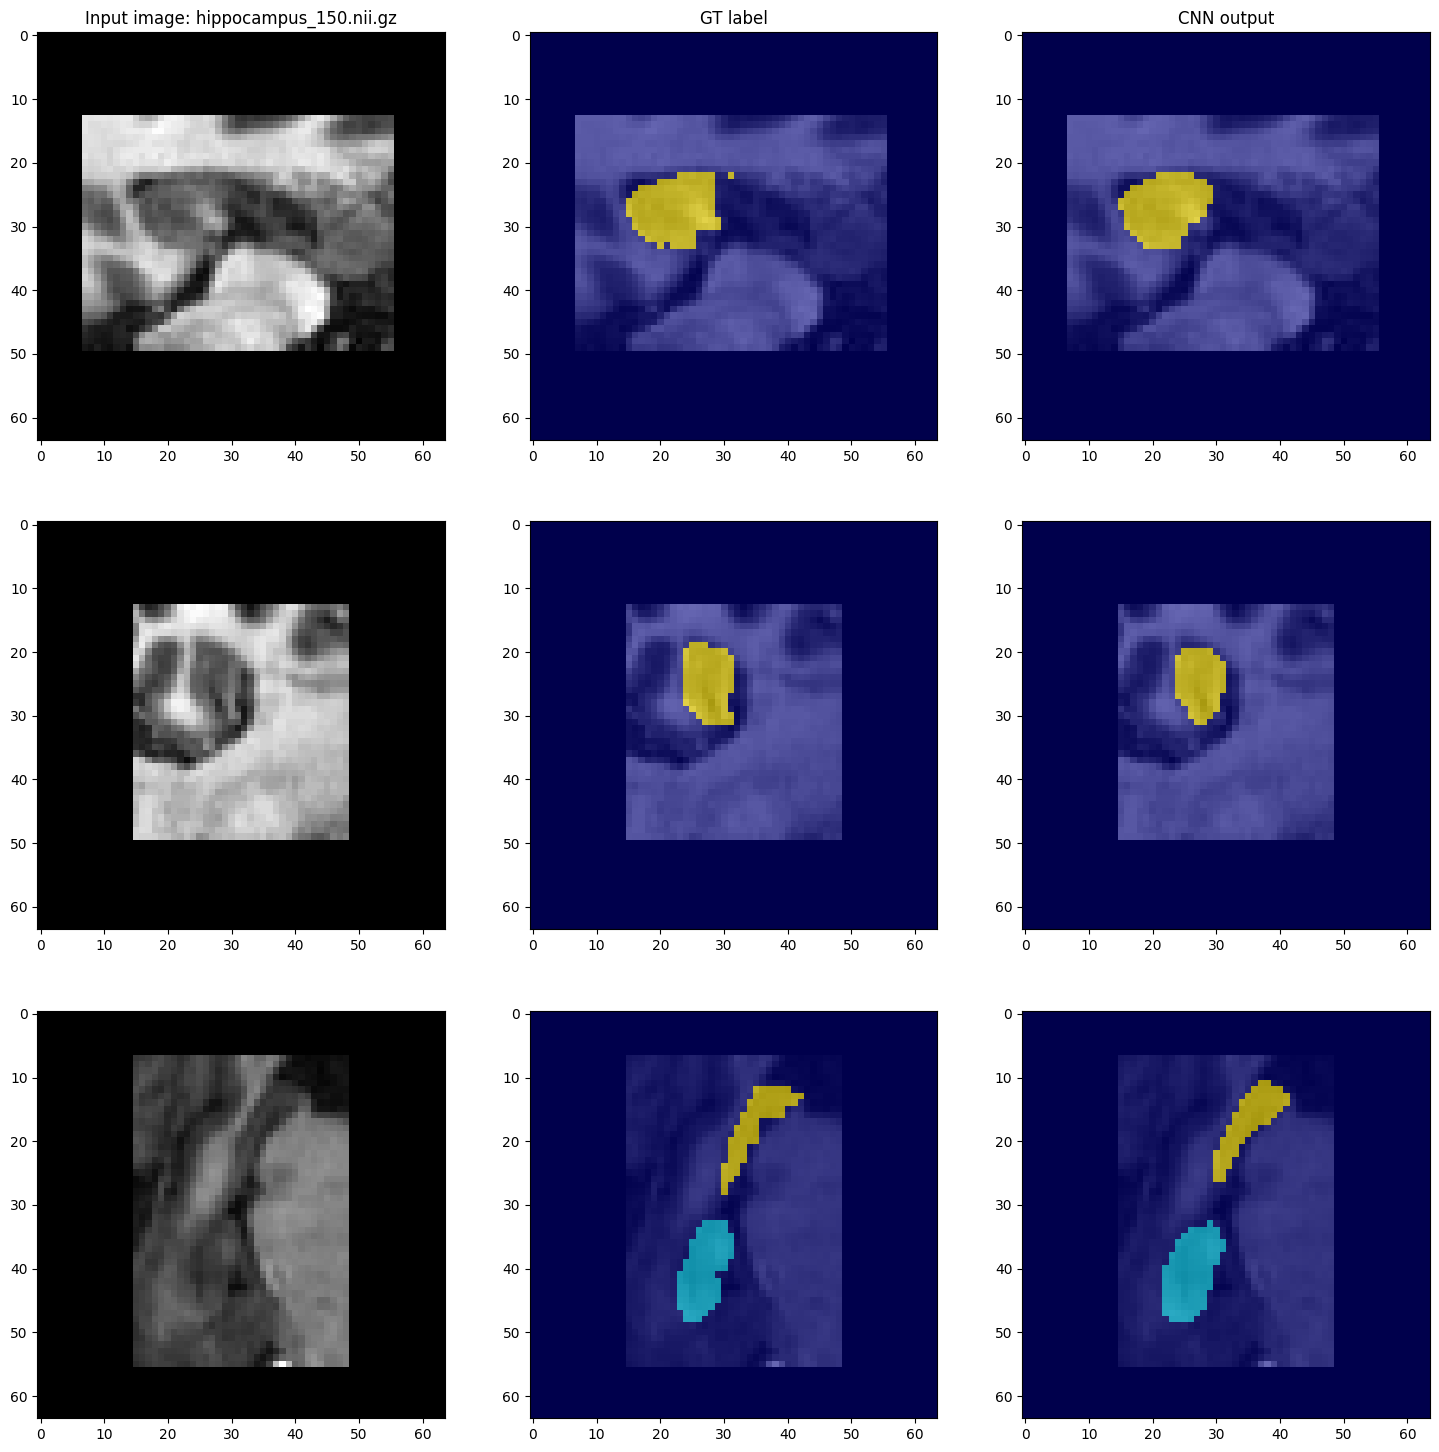

In [ ]:
# model = AttentionUnet(spatial_dims=3,
#                       in_channels=1,
#                       out_channels=3,
#                       channels=(32, 64, 128, 256, 512),
#                       strides=(2,2,2,2),
#                       kernel_size=3,
#                       up_kernel_size=3,
#                       dropout=0.0
#                       ).to(device)


while global_step < max_iterations:
    global_step, dice_val_best, global_step_best = train(
        global_step, train_loader, dice_val_best, global_step_best
    )


plt.figure("train", (12, 6))
plt.subplot(1, 2, 1)
plt.title("Iteration Average Loss")
x = [eval_num * (i + 1) for i in range(len(epoch_loss_values))]
y = epoch_loss_values
plt.xlabel("Iteration")
plt.plot(x, y)
plt.subplot(1, 2, 2)
plt.title("Val Mean Dice")
x = [eval_num * (i + 1) for i in range(len(metric_values))]
y = metric_values
plt.xlabel("Iteration")
plt.plot(x, y)
plt.show()

case_num = 1

class_n = 3
qq=round(img_dim/2)
alpha_val = 0.6
with torch.no_grad():
    img_name = os.path.split(val_ds[case_num]["image_meta_dict"]["filename_or_obj"])[1]
    cur_case = val_ds[case_num]
    img = cur_case["image"]
    label = cur_case["label"]
    val_inputs = torch.unsqueeze(img, 1).cuda()
    val_labels = torch.unsqueeze(label, 1).cuda()
    val_outputs = sliding_window_inference(
        val_inputs, (img_dim, img_dim, img_dim), 4, model, overlap=0.8
    )
    plt.figure("check", (18, 18))
    plt.subplot(3, 3, 1)
    plt.title(f"Input image: {img_name}")
    plt.imshow(val_inputs.cpu().numpy()[0, 0, :, :, qq], cmap="gray")
    plt.subplot(3, 3, 2)
    plt.title("GT label")
    plt.imshow(val_inputs.cpu().numpy()[0, 0, :, :, qq], cmap="gray")
    plt.imshow(val_labels.cpu().numpy()[0, 0, :, :, qq], alpha=alpha_val, vmin=0, vmax=class_n, cmap="jet")
    plt.subplot(3, 3, 3)
    plt.title("CNN output")
    plt.imshow(val_inputs.cpu().numpy()[0, 0, :, :, qq], cmap="gray")
    plt.imshow(torch.argmax(val_outputs, dim=1).detach().cpu()[0, :, :, qq], alpha=alpha_val, vmin=0, vmax=class_n, cmap="jet")

    plt.subplot(3, 3, 4)
    plt.imshow(val_inputs.cpu().numpy()[0, 0, :, qq, :], cmap="gray")
    plt.subplot(3, 3, 5)
    plt.imshow(val_inputs.cpu().numpy()[0, 0, :, qq, :], cmap="gray")
    plt.imshow(val_labels.cpu().numpy()[0, 0, :, qq, :], alpha=alpha_val, vmin=0, vmax=class_n, cmap="jet")
    plt.subplot(3, 3, 6)
    plt.imshow(val_inputs.cpu().numpy()[0, 0, :, qq, :], cmap="gray")
    plt.imshow(torch.argmax(val_outputs, dim=1).detach().cpu()[0, :, qq, :], alpha=alpha_val, vmin=0, vmax=class_n, cmap="jet")


    plt.subplot(3, 3, 7)
    plt.imshow(val_inputs.cpu().numpy()[0, 0, qq, :, :], cmap="gray")
    plt.subplot(3, 3, 8)
    plt.imshow(val_inputs.cpu().numpy()[0, 0, qq, :, :], cmap="gray")
    plt.imshow(val_labels.cpu().numpy()[0, 0, qq, :, :], alpha=alpha_val, vmin=0, vmax=class_n, cmap="jet")
    plt.subplot(3, 3, 9)
    plt.imshow(val_inputs.cpu().numpy()[0, 0, qq, :, :], cmap="gray")
    plt.imshow(torch.argmax(val_outputs, dim=1).detach().cpu()[0, qq, :, :], alpha=alpha_val, vmin=0, vmax=class_n, cmap="jet")
# attention UNET
    plt.show()

# Ensemble

In [ ]:
# recall the dataset from STEP3
from monai.transforms import CenterSpatialCropd, SpatialPadd, ScaleIntensityd
from torch.optim import AdamW
degree_min = -3
degree_max = 3

training_transforms2 = Compose(
    [
        LoadImaged(keys=["image", "label"]),
        AddChanneld(keys=["image", "label"]),
        ScaleIntensityd(keys=["image"], minv=0.0, maxv=1.0),
        SpatialPadd(keys=["image", "label"], spatial_size=[64, 64, 64]),

        RandAffined(
            keys=["image", "label"],
            rotate_range=[(degree_min,degree_max),(degree_min,degree_max),(degree_min,degree_max)],
            mode=("bilinear", "nearest"),
            padding_mode=("zeros"),
            prob=0.5),

        RandGaussianSharpend(keys=['image'],
                            sigma1_x=(0.5, 1.5),
                            sigma1_y=(0.5, 1.5),
                            sigma1_z=(0.5, 1.5),
                            sigma2_x=(0.1, 0.5),
                            sigma2_y=(0.1, 0.5),
                            sigma2_z=(0.1, 0.5),
                            alpha=(10.0, 30.0),
                            prob=0.5),
        ToTensord(keys=["image", "label"])
    ]
)


validation_transforms2 = Compose(
    [
        LoadImaged(keys=["image", "label"]),
        AddChanneld(keys=["image", "label"]),
        ScaleIntensityd(keys=["image"], minv=0.0, maxv=1.0),
        SpatialPadd(keys=["image", "label"], spatial_size=[64, 64, 64]),
        ToTensord(keys=["image", "label"])
    ]
)


# Training Datasets and DataLoader
train_ds = CacheDataset(data=train_datalist, transform=training_transforms2, cache_rate=1.0, num_workers=4)
train_loader = DataLoader(train_ds, batch_size=2, shuffle=True, num_workers=4, pin_memory=True)

# Valdiation dataset and DataLoader
val_ds = CacheDataset(data=val_datalist, transform=validation_transforms2, cache_rate=1.0, num_workers=4)
val_loader = DataLoader(val_ds, batch_size=2, shuffle=False, num_workers=4, pin_memory=True)

print(f"Training dataset size: {len(train_ds)}")
print(f"Validation dataset size: {len(val_ds)}")


Loading dataset: 100%|██████████| 78/78 [00:00<00:00, 106.78it/s]

Training dataset size: 182
Validation dataset size: 78


In [ ]:
max_iterations = 1500
eval_num = 300
post_label = AsDiscrete(to_onehot=3)
post_pred = AsDiscrete(argmax=True, to_onehot=3)
dice_metric = DiceMetric(include_background=True, reduction="mean", get_not_nans=False)
global_step = 0
dice_val_best = 0.0
global_step_best = 0
epoch_loss_values = []
metric_values = []

In [ ]:
save_dir = '/content/drive/MyDrive/RESIT/Save'

def validation(epoch_iterator_val):
    model.eval()
    dice_vals = list()
    with torch.no_grad():
        for step, batch in enumerate(epoch_iterator_val):
            val_inputs, val_labels = (batch["image"].cuda(), batch["label"].cuda())
            val_outputs = sliding_window_inference(val_inputs, (img_dim, img_dim, img_dim), 4, model)
            val_labels_list = decollate_batch(val_labels)
            val_labels_convert = [
                post_label(val_label_tensor) for val_label_tensor in val_labels_list
            ]
            val_outputs_list = decollate_batch(val_outputs)
            val_output_convert = [
                post_pred(val_pred_tensor) for val_pred_tensor in val_outputs_list
            ]
            dice_metric(y_pred=val_output_convert, y=val_labels_convert)
            dice = dice_metric.aggregate().item()
            dice_vals.append(dice)
            epoch_iterator_val.set_description(
                "Validate (%d / %d Steps) (dice=%2.5f)" % (global_step, 10.0, dice)
            )
        dice_metric.reset()
    mean_dice_val = np.mean(dice_vals)
    return mean_dice_val


def train(global_step, train_loader, dice_val_best, global_step_best):
    model.train()
    epoch_loss = 0
    step = 0
    epochs_no_improve = 0 #
    max_epochs_no_improve = 20 # patients
    epoch_iterator = tqdm(
        train_loader, desc="Training (X / X Steps) (loss=X.X)", dynamic_ncols=True
    )
    for step, batch in enumerate(epoch_iterator):
        step += 1
        x, y = (batch["image"].cuda(), batch["label"].cuda())
        logit_map = model(x)
        loss = loss_function(logit_map, y)
        loss.backward()
        epoch_loss += loss.item()
        optimizer.step()
        optimizer.zero_grad()
        epoch_iterator.set_description(
            "Training (%d / %d Steps) (loss=%2.5f)" % (global_step, max_iterations, loss)
        )
        if (
            global_step % eval_num == 0 and global_step != 0
        ) or global_step == max_iterations:
            epoch_iterator_val = tqdm(
                val_loader, desc="Validate (X / X Steps) (dice=X.X)", dynamic_ncols=True
            )
            dice_val = validation(epoch_iterator_val)
            epoch_loss /= step
            epoch_loss_values.append(epoch_loss)
            metric_values.append(dice_val)
            if dice_val > dice_val_best:
                dice_val_best = dice_val
                epochs_no_improve = 0
                global_step_best = global_step
                torch.save(
                    model.state_dict(), os.path.join(save_dir, ("Ensamble.pth"))
                )
                print(
                    "Model Was Saved ! Current Best Avg. Dice: {} Current Avg. Dice: {}".format(
                        dice_val_best, dice_val
                    )
                )
            else:
                epochs_no_improve += 1
                torch.save(
                    model.state_dict(), os.path.join(save_dir, ("Ensamble.pth"))
                )
                print(
                    "Model Was Not Saved ! Current Best Avg. Dice: {} Current Avg. Dice: {}".format(
                        dice_val_best, dice_val
                    )
                )
                print("[{}/20]".format(epochs_no_improve))
            if epochs_no_improve == max_epochs_no_improve:
                print("Early stopping!")
                break
        global_step += 1
    return global_step, dice_val_best, global_step_best




In [ ]:
import copy

# Set the parameters for the models
models_parameters = []

# Model initialization
model = RegUNet(
    spatial_dims=3,
    in_channels=1,
    num_channel_initial=32,
    depth=3,
    out_kernel_initializer='kaiming_uniform',
    out_activation='relu',
    out_channels=3,
    extract_levels=None,
    pooling=False,
    concat_skip=False,
    encode_kernel_sizes=3
).to(device)

opt = [torch.optim.Adam(model.parameters(), lr=3e-4),
       torch.optim.AdamW(model.parameters(), weight_decay=1e-4, lr=3e-4),
       torch.optim.SGD(model.parameters(), momentum=0.9, weight_decay=1e-4, lr=3e-4)]

models = []
losses_for_each_optimizer = []
metrics_for_each_optimizer = []

for optimizer_option in opt:
    # 각 옵티마이저마다 새로운 모델을 초기화
    model = RegUNet(
        spatial_dims=3,
        in_channels=1,
        num_channel_initial=32,
        depth=3,
        out_kernel_initializer='kaiming_uniform',
        out_activation='relu',
        out_channels=3,
        extract_levels=None,
        pooling=False,
        concat_skip=False,
        encode_kernel_sizes=3
    ).to(device)

    print(f"Training model with optimizer={optimizer_option}")

    # Loss Function
    loss_function = DiceLoss(
        include_background=True,
        to_onehot_y=True,
        sigmoid=True,
        jaccard=True,
        squared_pred=False
    )

    # Optimizers
    if optimizer_option == torch.optim.Adam:
        optimizer = optimizer_option(model.parameters(), lr=3e-4)
    elif optimizer_option == torch.optim.AdamW:
        optimizer = optimizer_option(model.parameters(), weight_decay=1e-4, lr=3e-4)
    elif optimizer_option == torch.optim.SGD:
        optimizer = optimizer_option(model.parameters(), momentum=0.9, weight_decay=1e-4, lr=3e-4)

    while global_step < max_iterations:
        global_step, dice_val_best, global_step_best = train(
            global_step, train_loader, dice_val_best, global_step_best
        )

    models.append(model)
    losses_for_each_optimizer.append(epoch_loss_values.copy())
    metrics_for_each_optimizer.append(metric_values.copy())


Training model with optimizer=Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    capturable: False
    differentiable: False
    eps: 1e-08
    foreach: None
    fused: None
    lr: 0.0003
    maximize: False
    weight_decay: 0
)


Training (301 / 1500 Steps) (loss=0.82114):  32%|███▏      | 29/91 [00:10<01:08,  1.10s/it]

Model Was Saved ! Current Best Avg. Dice: 0.17521085150730917 Current Avg. Dice: 0.17521085150730917


Training (601 / 1500 Steps) (loss=0.81893):  62%|██████▏   | 56/91 [00:15<00:36,  1.05s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.17521085150730917 Current Avg. Dice: 0.15807727284920522
[1/20]


Training (901 / 1500 Steps) (loss=0.82375):  91%|█████████ | 83/91 [00:20<00:08,  1.03s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.17521085150730917 Current Avg. Dice: 0.1691855604831989
[1/20]


Training (1201 / 1500 Steps) (loss=0.82195):  21%|██        | 19/91 [00:08<01:15,  1.04s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.17521085150730917 Current Avg. Dice: 0.16519784545287108
[1/20]


Training (1501 / 1500 Steps) (loss=0.82002):  51%|█████     | 46/91 [00:13<00:46,  1.02s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.17521085150730917 Current Avg. Dice: 0.1677416349068666
[1/20]


Training (1546 / 1500 Steps) (loss=0.82156): 100%|██████████| 91/91 [00:21<00:00,  4.24it/s]


Training model with optimizer=AdamW (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    capturable: False
    differentiable: False
    eps: 1e-08
    foreach: None
    fused: None
    lr: 0.0003
    maximize: False
    weight_decay: 0.0001
)
Training model with optimizer=SGD (
Parameter Group 0
    dampening: 0
    differentiable: False
    foreach: None
    lr: 0.0003
    maximize: False
    momentum: 0.9
    nesterov: False
    weight_decay: 0.0001
)


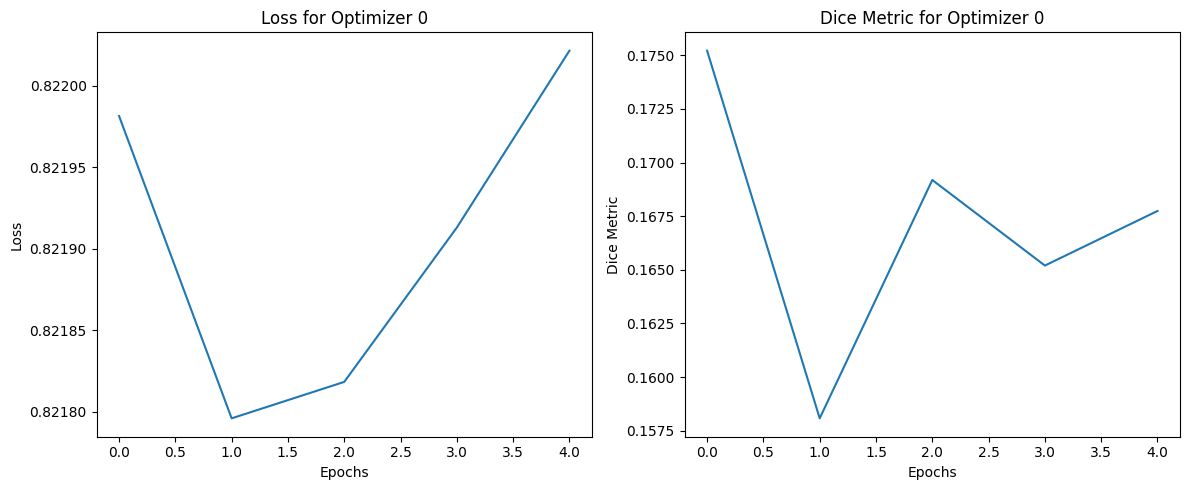

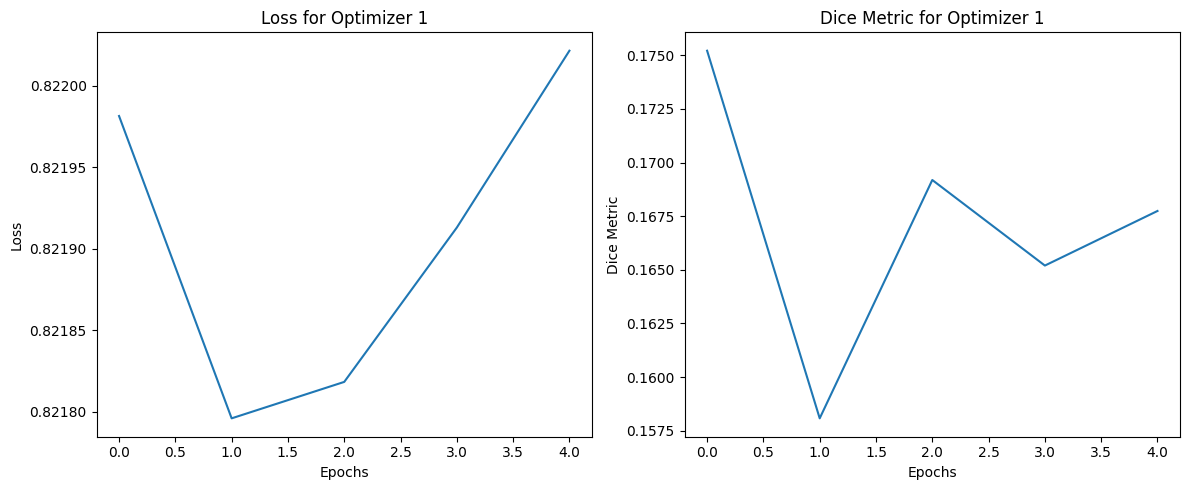

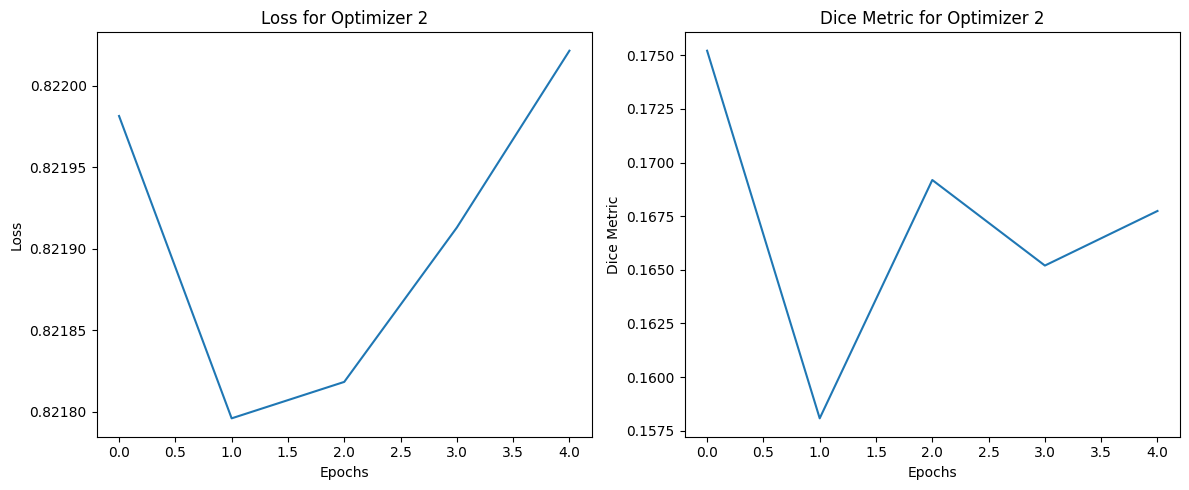

In [ ]:
for i, (losses, metrics) in enumerate(zip(losses_for_each_optimizer, metrics_for_each_optimizer)):
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(losses, label=f"Optimizer {i}")
    plt.title(f"Loss for Optimizer {i}")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")

    plt.subplot(1, 2, 2)
    plt.plot(metrics, label=f"Optimizer {i}")
    plt.title(f"Dice Metric for Optimizer {i}")
    plt.xlabel("Epochs")
    plt.ylabel("Dice Metric")
    plt.tight_layout()
    plt.show()

# Ensemble predictions (assuming you have a data sample)
def ensemble_predictions(models, data):
    predictions = [model(data).detach() for model in models]
    avg_prediction = sum(predictions) / len(models)
    return avg_prediction

# Assuming you have a sample data point for prediction
sample_data = torch.randn(1, 1, 128, 128, 128).to(device)  # Example data, replace with a real sample
avg_pred = ensemble_predictions(models, sample_data)

# OVERVIEW
- Esamble with 3 different type of optimisers (SGD, ADAM, ADAMW)
- However, I could not build the code
- We expect that these 3 optimisers represents the most sginificant result, respectively.
- It is enough to try as ensamble